### Announcements

✅ Clinic 1 grades are available. 

<img src="img/clinic1-grades.png" alt="Grade Distribution" width="50%">

⏳ Clinic 2 grading is underway!

### Announcements

⏰ Reminder about tomorrow:
- 0930-1030 DA-ORCS crossover at MSM Lecture Hall
- 1100-1300 Clinic 5/Bootcamp on Timeseries

🎭 After carnival:
- Monday 10th 1330-1530 Last lecture: on data distribution shifts, model monitoring, a bit on scaling, wrap-up
- Thursday 13th 1330-1530: Exam prep (tips & tricks, hacks and past exams)

# Data Analysis

## Temporal Data Analysis: A gentle intro to timeseries

Timeseries analysis can be a course (or multiple courses) on its own but in this lecture we will try to cover some basics, namely:

* a general intro to temporal data analysis 
* visualizing time series 
* exploring properties of a time series (trend, seasonality, rolling statistics)
* transformations on timeseries and stationarity
* building basic forecasting models (ARIMA as a baseline)
* practical applications (tomorrow in clinic)

Further reading: 
+ Yves Hilpisch, Python for Finance, O'Reilly, (2014)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
#plt.style.use('fivethirtyeight')
#plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15, 6)

import warnings
warnings.filterwarnings('ignore')

import plotly.express as px
import plotly.io as pio
pio.renderers.default = "iframe"

import sys
sys.path.insert(0, '.')

import warnings
warnings.filterwarnings('ignore')

#this is a file containing some potentially useful functions
from utils import *

## 0. Temporal data analysis

A *time series* is a series of data points indexed by time, $x_i = x(t_i)$, for $i=1,\ldots,n$. Examples frequently occur in 
* weather forecasting, 
* mathematical finance (stocks),
* electricity demand in a power grid, 
* COVID-19 cases per day, and in general...
* any applied science and engineering which involves temporal measurements

*Temporal data analysis* or *time series analysis* is just the study of such data. 

We want to observe the timeseries and draw conclusions: 
+ Descriptive/Exploratory, e.g. estimating summary measures (such as mean (trend), variance)
+ Inferential: Understanding / Modeling
+ Prediction/Forecasting



<img src="img/wooclap.png" alt="wooclap" width="40%">

### POLL: Which is easiest to forecast? Think of factors that contributed to your ranking 

+ daily electricity demand in 3 days time
<br>
+ time of sunrise this day next year
<br>
+ Apple stock price tomorrow
<br>
+ Apple stock price in 6 months time 
<br>
+ maximum temperature tomorrow
<br>
+ exchange rate of $US / EUR next week
<br>
+ total sales of drugs in Netherlands pharmacies next month 
<br>
+ timing of next Halley’s comet appearance


## 1. Looking into the data

As with every new dataset, the first step is to load data and inspect it. We are going to be using an example from the Retail Sales Index on Alcoholic Drinks which gives us the monthly estimate of retail sales in value and volume terms for Great Britain (years 1988 till 2023). You can find the original data [here](https://www.ons.gov.uk/businessindustryandtrade/retailindustry/timeseries/cy45)

Let's load this dataset into pandas!

In [2]:
alcohol = pd.read_csv("data/alcohol2024.csv", header=None, skiprows=8, parse_dates=[0], names=['period', 'value'])
alcohol.value.astype(int, copy=False);
alcohol.head(10)

period  value
0 1988-01-01  119.8
1 1988-02-01  125.3
2 1988-03-01  131.4
3 1988-04-01  134.9
4 1988-05-01  136.8
5 1988-06-01  136.9
6 1988-07-01  139.6
7 1988-08-01  144.3
8 1988-09-01  134.6
9 1988-10-01  137.8

In [3]:
max_date = alcohol.period.max()
min_date = alcohol.period.min()

num_of_actual_points = alcohol.index.shape[0]
num_of_expected_points = (max_date.year - min_date.year) * 12 + max_date.month - min_date.month + 1

print("Date range: {} - {}".format(min_date.strftime("%d.%m.%Y"), max_date.strftime("%d.%m.%Y")))
print("Number of data points: {} of expected {}".format(num_of_actual_points, num_of_expected_points))


Date range: 01.01.1988 - 01.01.2024
Number of data points: 433 of expected 433


### Visualize the data

We already hinted that the observations might not be independent, another issue we see from plotting the series is that there is more structure in the data (in the form of a trend and a seasonality). Moreover, there can be external events that might affect the value of the timeseries.

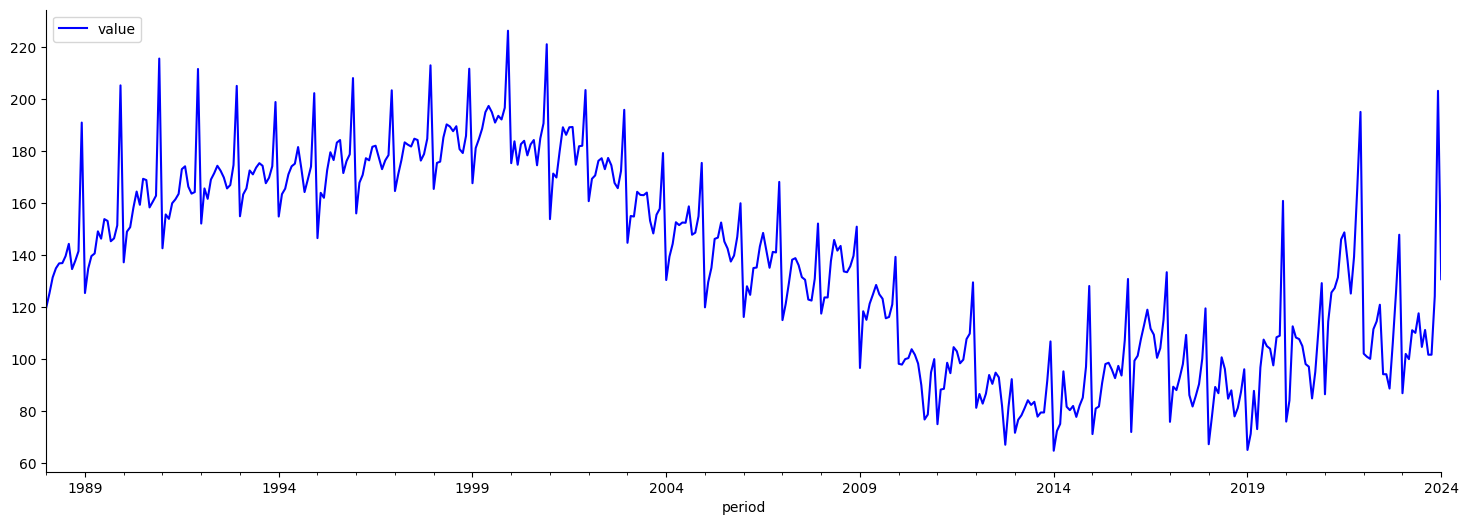

In [4]:
fig, ax = plt.subplots(figsize=(18,6))
alcohol.plot(x="period", y="value", color="blue", ax=ax)
plt.legend(loc='upper left')
#plt.savefig('images/intro-visualization.png');

We can also zoom-in to check specific periods of time

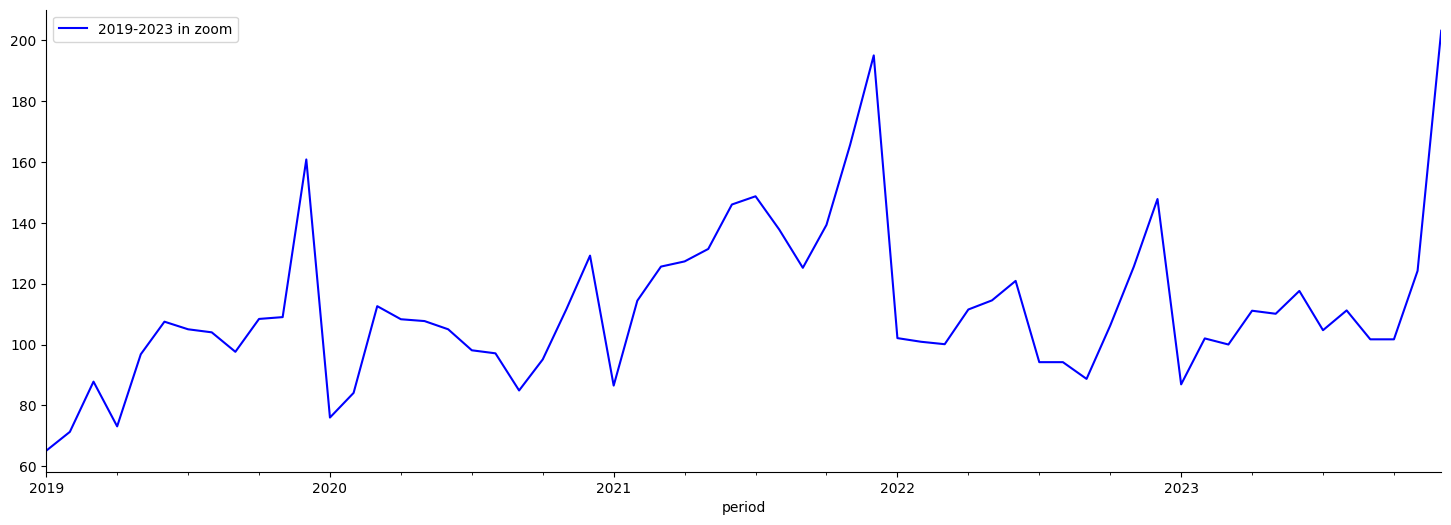

In [5]:
zoom_range = alcohol[(alcohol.period >= '2019-01-01') & (alcohol.period < '2024-01-01')].index

fig, ax = plt.subplots(figsize=(18,6))
alcohol.loc[zoom_range].plot(x="period", y="value", ax=ax, color="blue", label="2019-2023 in zoom")
plt.legend(loc='upper left')

#plt.savefig('images/intro-zoom.png');

Before we move on, let's see two more visualizations of two other datasets and let's try to make some observations.

In [6]:
pd.read_csv('data/ansett.csv').head(3)

Week Airports     Class  Passengers
0  1989 W28  ADL-PER  Business         193
1  1989 W29  ADL-PER  Business         254
2  1989 W30  ADL-PER  Business         185

In [7]:
def ansett_parse_week(week):
    y = int(week[:4])
    w = int(week[-2:])
    return pd.to_datetime(y, format='%Y') + pd.to_timedelta(w, 'w')

In [8]:
ansett = pd.read_csv('data/ansett.csv',parse_dates=['Week'], date_parser=ansett_parse_week)
ansett

Week Airports     Class  Passengers
0    1989-07-16  ADL-PER  Business         193
1    1989-07-23  ADL-PER  Business         254
2    1989-07-30  ADL-PER  Business         185
3    1989-08-06  ADL-PER  Business         254
4    1989-08-13  ADL-PER  Business         191
...         ...      ...       ...         ...
7402 1992-10-28  SYD-PER     First         203
7403 1992-11-04  SYD-PER     First         137
7404 1992-11-11  SYD-PER     First         161
7405 1992-11-18  SYD-PER     First         155
7406 1992-11-25  SYD-PER     First         188

[7407 rows x 4 columns]

In [9]:
melsyd_economy = ansett.query("Airports == 'MEL-SYD' and Class == 'Economy'")
melsyd_economy

Week Airports    Class  Passengers
3881 1987-07-02  MEL-SYD  Economy       20167
3882 1987-07-09  MEL-SYD  Economy       20161
3883 1987-07-16  MEL-SYD  Economy       19993
3884 1987-07-23  MEL-SYD  Economy       20986
3885 1987-07-30  MEL-SYD  Economy       20497
...         ...      ...      ...         ...
4158 1992-10-28  MEL-SYD  Economy       28837
4159 1992-11-04  MEL-SYD  Economy       26548
4160 1992-11-11  MEL-SYD  Economy       27279
4161 1992-11-18  MEL-SYD  Economy       27306
4162 1992-11-25  MEL-SYD  Economy       28299

[282 rows x 4 columns]

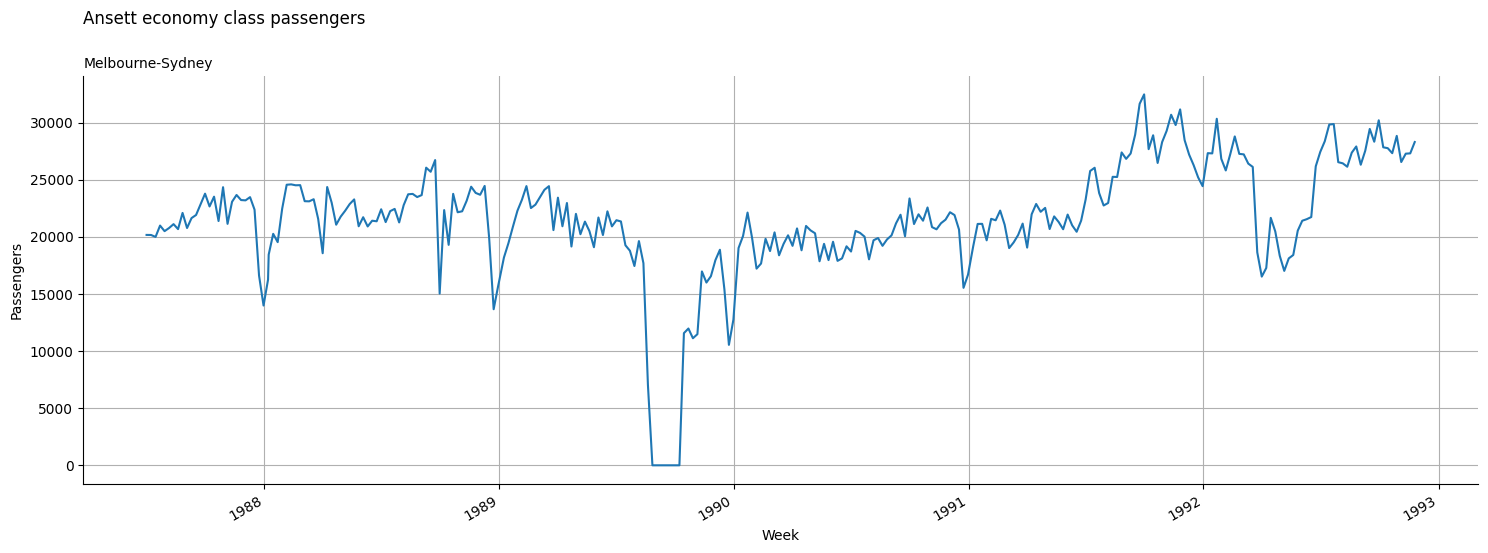

In [10]:
ax = melsyd_economy.set_index("Week")["Passengers"].plot()
suptitle('Ansett economy class passengers')
ax.set(ylabel='Passengers', title='Melbourne-Sydney')
ax.grid()

In [11]:
PBS = pd.read_csv('data/PBS.csv', parse_dates=['Month'])
#PBS
a10 = (
    PBS
    .query('ATC2 == "A10"')
    .groupby('Month', sort=False)
    .pipe(summarize, lambda x: dict(Cost = x.Cost.sum() / 1e6))
    .reset_index()
    .set_index('Month', drop=False)
)
a10

Month       Cost
Month                           
1991-07-01 1991-07-01   3.526591
1991-08-01 1991-08-01   3.180891
1991-09-01 1991-09-01   3.252221
1991-10-01 1991-10-01   3.611003
1991-11-01 1991-11-01   3.565869
...               ...        ...
2008-02-01 2008-02-01  21.654285
2008-03-01 2008-03-01  18.264945
2008-04-01 2008-04-01  23.107677
2008-05-01 2008-05-01  22.912510
2008-06-01 2008-06-01  19.431740

[204 rows x 2 columns]

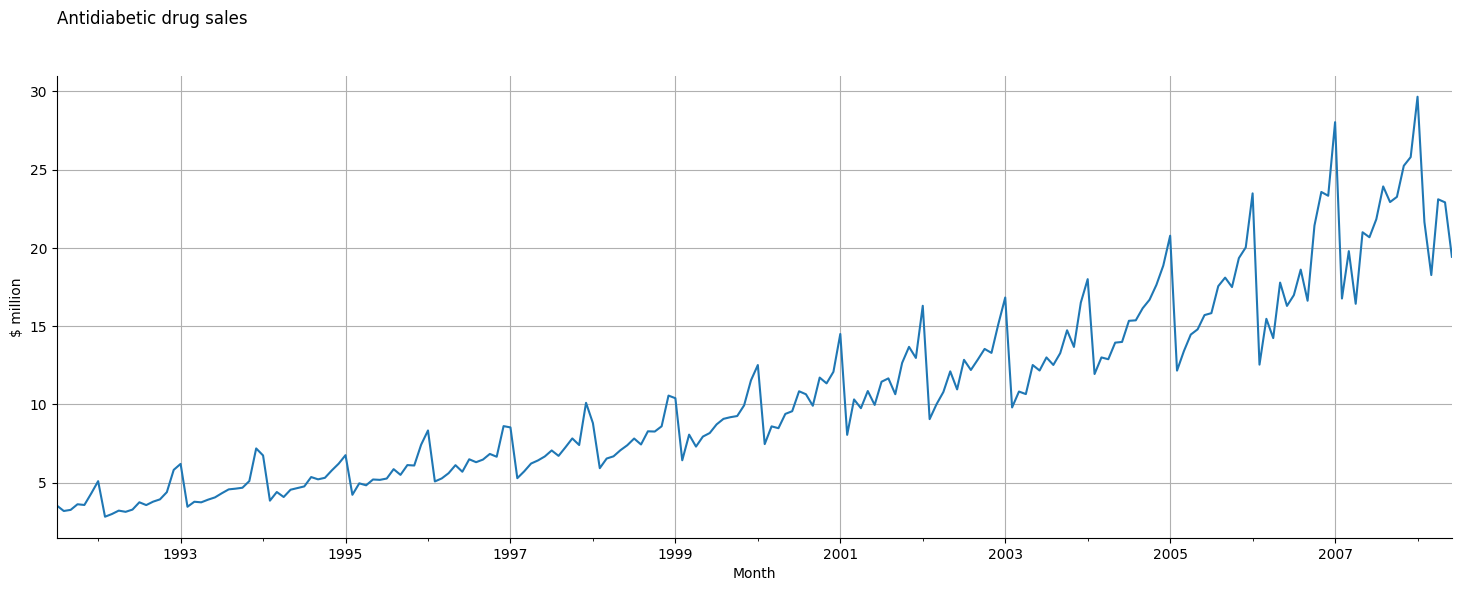

In [12]:
ax = a10.Cost.plot(figsize=sizets)
suptitle('Antidiabetic drug sales')
ax.set(ylabel='$ million')
ax.grid()

### 1.1 Initial exploration: Trend and seasonality

From the visualizations (about drug and alcohol) it's quite obvious that some timeseries have periodic fluctuations each year and the general tendency to grow.

- Trend pattern exists when there is a long-term increase or decrease in the data.
- A seasonal  pattern exists when a series is inﬂuenced by seasonal  factors (e.g., the quarter of the year, the month, or day of  the week).
- That is different than the cyclic pattern that exists when data exhibit rises and falls that are not  of ﬁxed period (duration usually of at least 2 years).

Thus, we can conclude that the time series has a **trend** and yearly **seasonality** components, and we can try to identify them either using our own models, or tools available via **statsmodels** package (see [documentation](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html) and [code](https://www.statsmodels.org/stable/_modules/statsmodels/tsa/seasonal.html#seasonal_decompose) here).

### The Trend

What would be a reasonable approach to compute the trend?

Can i throw a linear regression at it?

<img src="img/wooclap.png" alt="wooclap" width="40%">

### POLL: Is running linear regression on time a good idea?


### Moving Average 

One way to compute the trend would be to compute moving averages as follows. 

For a time series $x_t$, the *$q$-day moving average at time $t$*, denoted $MA^q_t$, is the average of $x_t$ over the past $q$ days, 

$$
MA^q_t = \frac{1}{q} \sum_{i = 0}^{q-1} x_{t - i}
$$

We will see that MA can also be used to transform the series.

###  Decompositions

The classical decomposition method (we saw above) is a relatively simple procedure, and forms the starting point for most other methods of time series decomposition. There are two forms of classical decomposition: an additive decomposition and a multiplicative decomposition.

These are described below for a time series with seasonal period $m$ (e.g. $m=4$ for quarterly data, $m=12$ for monthly data, $m=7$ for daily data with a weekly pattern). In classical decomposition, we assume that the seasonal component is constant from year to year.

### Additive decomposition

#### Step 1
+ If $m$ is an even number, compute the trend-cycle component $\hat{T}$ using a $MA^{2m}$
+ If $m$ is an odd number, compute the trend-cycle component $\hat{T}$ using a $MA^{m}$

#### Step 2
Calculate the detrended series $y_t-\hat{T}$ .

#### Step 3
To estimate the seasonal component for each season, simply average the detrended values for that season.

e.g. with monthly data, the seasonal component for March is the average of all the detrended March values in the data. These seasonal component values might be further adjusted to ensure that they add to zero. This gives $\hat{S}$.

#### Step 4
The remainder component is calculated by subtracting the estimated seasonal and trend-cycle components:

$$R_t = y_t - \hat{T} - \hat{S}$$

In a similar way (by dividing and not subtracting), we also compute the multiplicative decomposition.

Let's see how such a decomposition will work

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompfreq = 12  # yearly seasonality
model = 'additive'

decomposition = seasonal_decompose(
    alcohol.set_index("period").value.interpolate("linear"),
    period = decompfreq,
    model=model)

trend = decomposition.trend
seasonal = decomposition.seasonal 
residual = decomposition.resid 

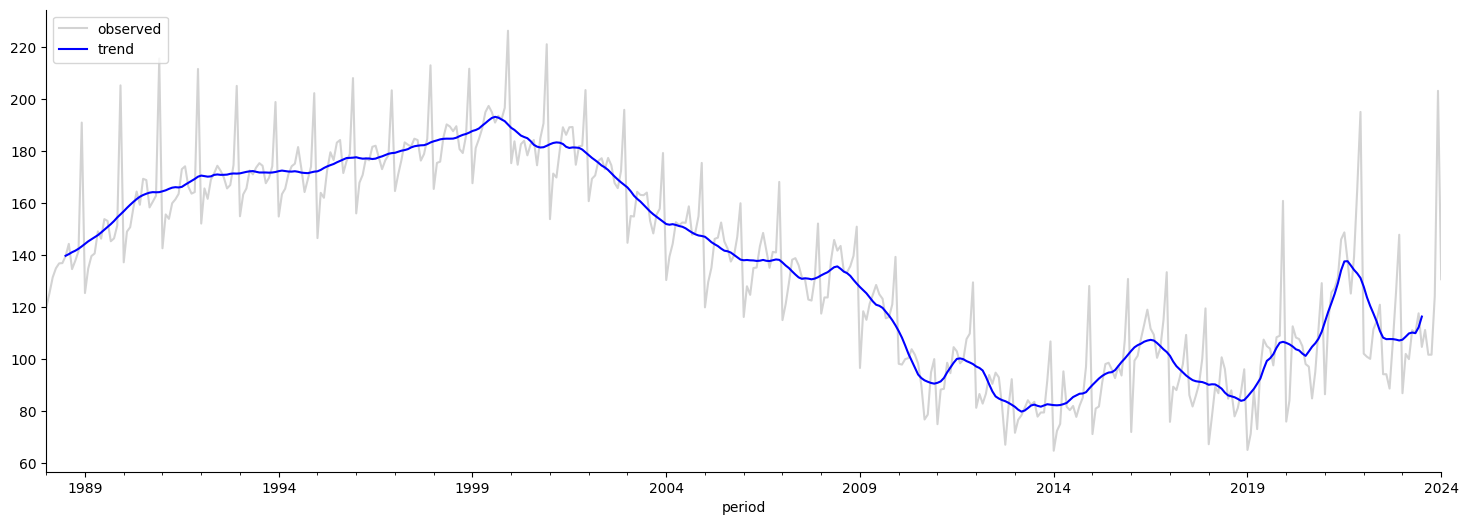

In [14]:
fig, ax = plt.subplots(figsize=(18,6))
alcohol.plot(x="period", y="value", ax=ax, label="observed", c='lightgrey')
trend.plot(ax=ax, label="trend", color="blue")
plt.legend(loc='upper left')

#plt.savefig('images/intro-trend.png');

### The Seasonality

There are many types of seasonality, e.g. time of day, daily, weekly, monthy, yearly, etc. As such, identifying whether there is a seasonality component in a time series depends on the specific context.

Once we identify the seasonality pattern, we can remove it from the data by differencing accordingly (e.g. in this example we identified a yearly seasonality (every 12 months).


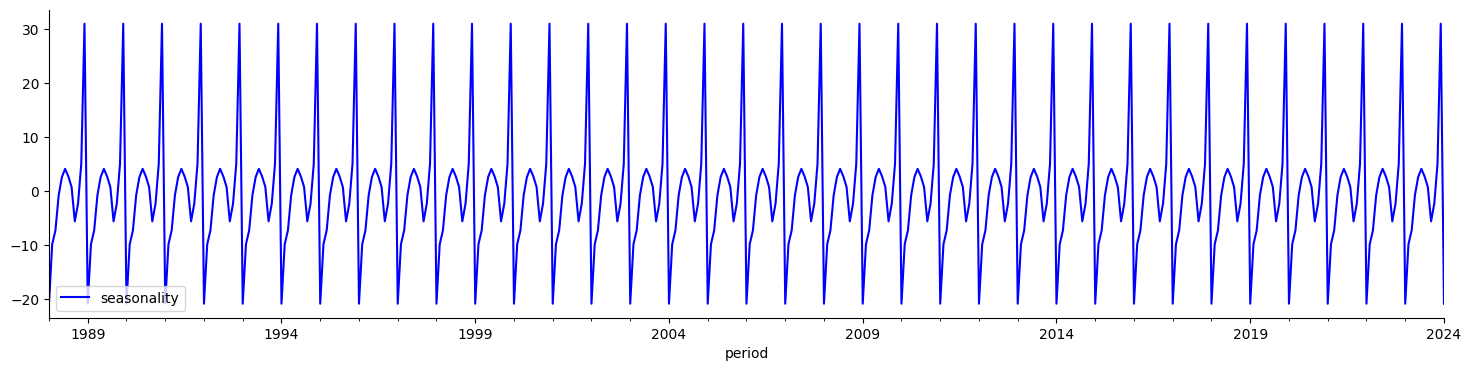

In [15]:
fig, ax = plt.subplots(figsize=(18,4))
seasonal.plot(ax=ax, label="seasonality", color="blue")
plt.legend(loc='lower left')

#plt.savefig('images/intro-seasonality.png');

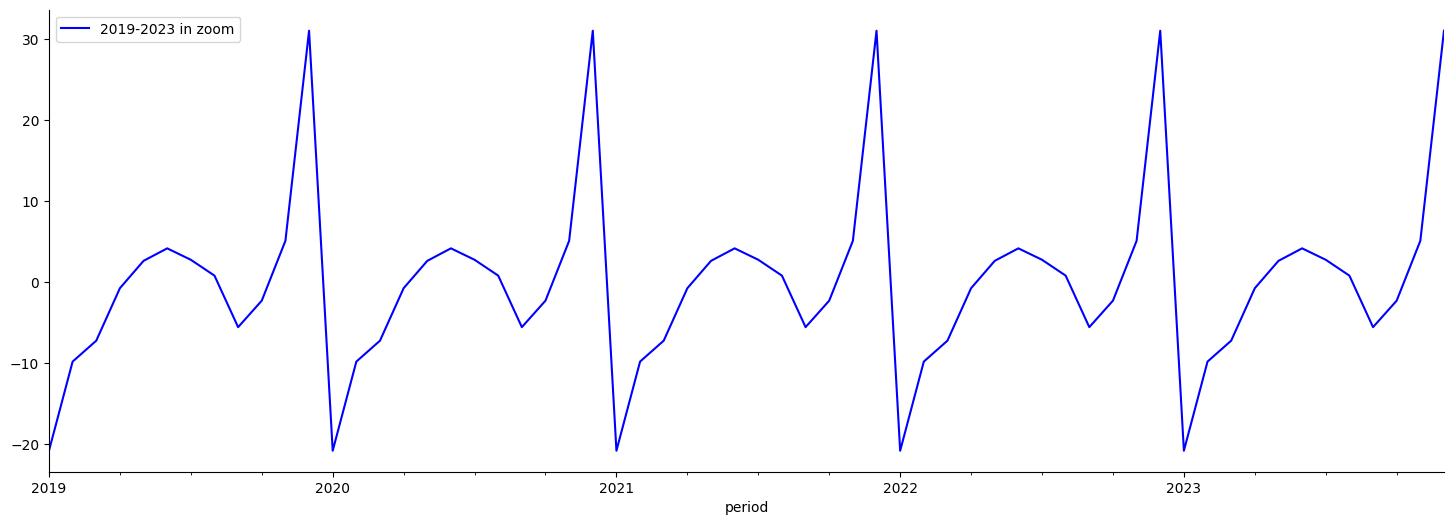

In [16]:
fig, ax = plt.subplots(figsize=(18,6))
seasonal[zoom_range].plot(x="period", y="value", color="blue", ax=ax, label="2019-2023 in zoom")
plt.legend(loc='upper left')

#plt.savefig('images/intro-seasonality-zoom.png');

### The Residual

Once we remove the trend and the seasonality, we are left with the remainder (or residual) part of the timeseries.

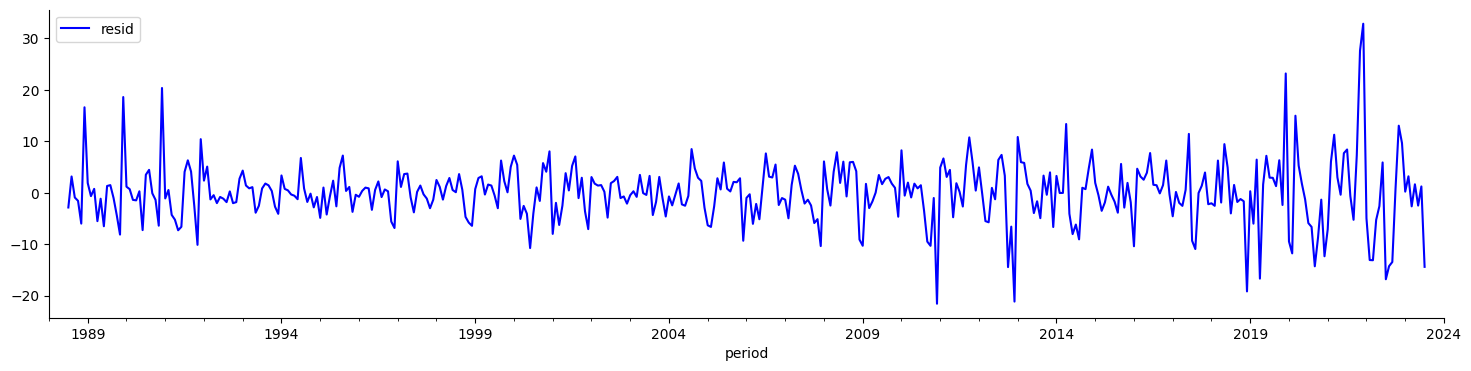

In [17]:
fig, ax = plt.subplots(figsize=(18,4))
residual.plot(ax=ax, legend="seasonality", color="blue")
plt.legend(loc='upper left')

#plt.savefig('images/intro-residual.png');

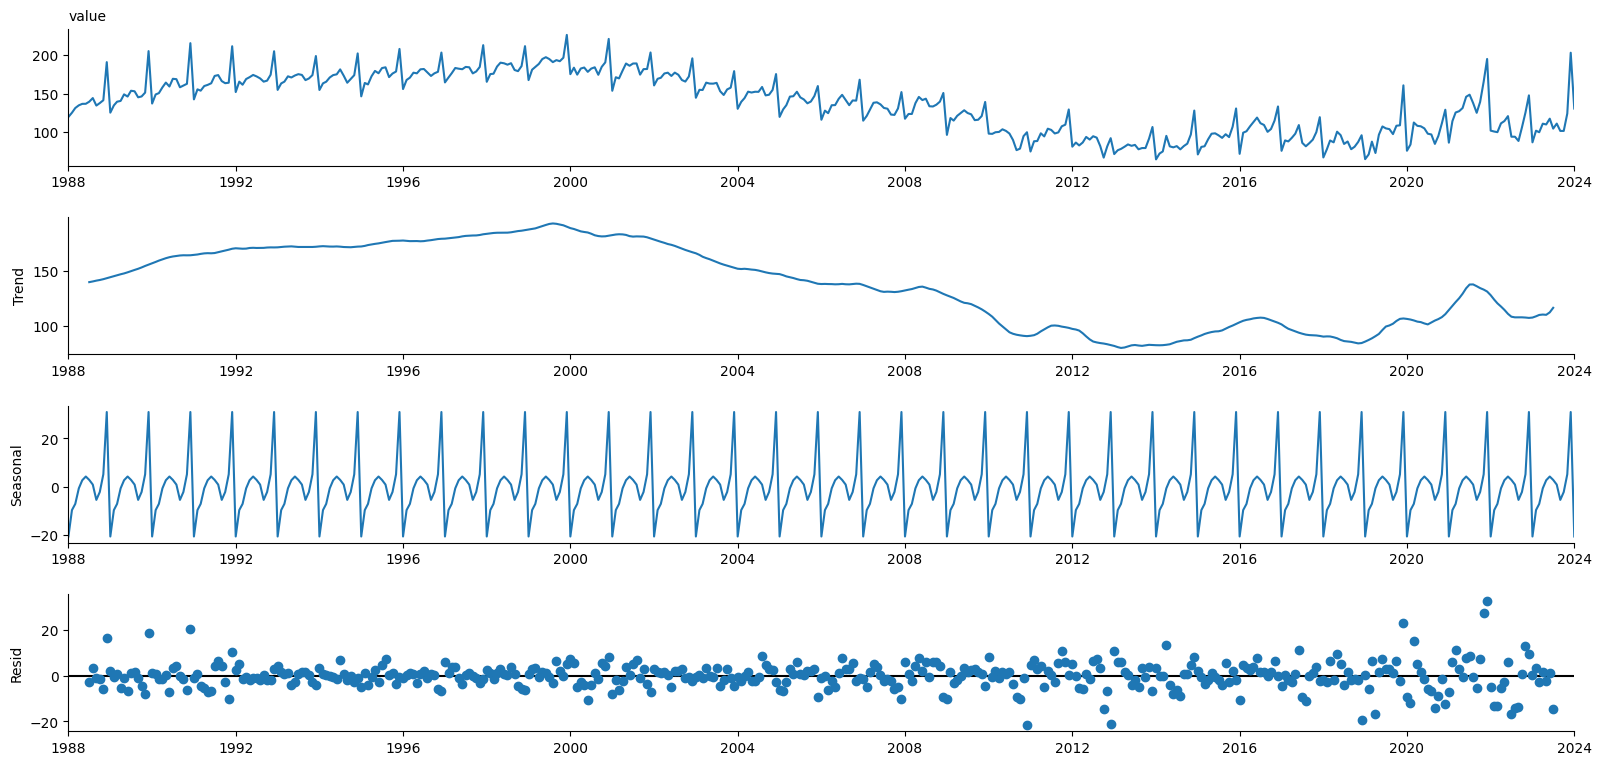

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasons = 12
decompfreq = seasons
model = 'additive'

decomposition = seasonal_decompose(
    alcohol.set_index("period").value.interpolate("linear"),
    period=decompfreq,
    model=model)

fig = decomposition.plot()
fig.set_size_inches(16, 8)

#plt.savefig('images/stochastic-decomposition.png');

## 2. Timeseries characteristics

Apart from the visual characteristics of the timeseries we might want to compute the (rolling) mean and the (rolling) standard deviation. This might be helpful to determine the behavior of the timseries over time.

### 2.1 Visual check using seasonal (rolling) statistics

In [19]:
#function for the visual check of rolling statistics
def visual_check(df, value, seasons, save_to=None):
    #double check this is correct!
    seasonal_mean = df.set_index("period").rolling(seasons).mean().reset_index()
    seasonal_std = df.set_index("period").rolling(seasons).std().reset_index()

    fig, ax = plt.subplots(figsize=(18,6))
    df.plot(x="period", y=value, ax=ax, label="observed", c='lightgrey')
    seasonal_mean.plot(x="period", y=value, ax=ax, label="seasonal (rolling) mean", c='blue')
    seasonal_std.plot(x="period", y=value, ax=ax, label="seasonal (rolling) std", c='green')

    plt.legend(loc='best')
    plt.title('Seasonal Mean & Standard Deviation')
    
    if save_to is not None:
        plt.savefig(save_to)
    plt.show();

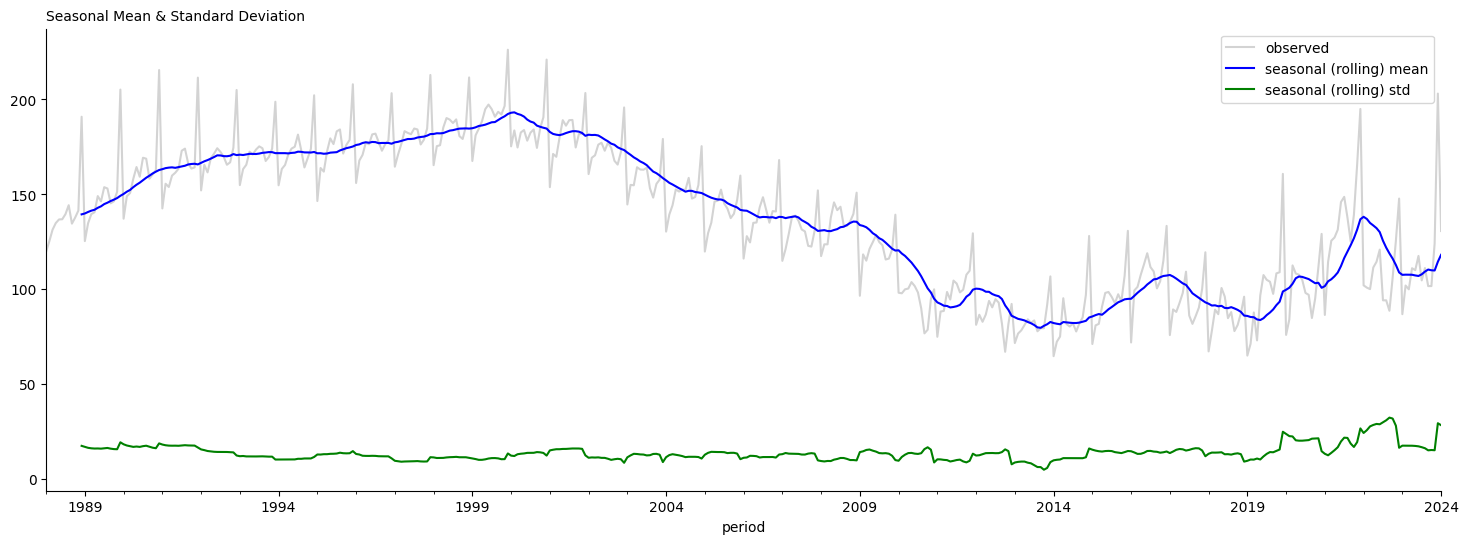

In [20]:
seasons = 12
visual_check(alcohol, "value", seasons)

### 2.2 The autocorrelation plot (or correlogram)

Let's see the intuition of autocorrelation plot with an example of data.

In [21]:
d = pd.read_csv('data/aus_production.csv')
recent_production = (
    d
    .assign(Date=pd.to_datetime(d.Quarter.str.replace(' ', '')))
    .pipe(compute, lambda x: dict(Year=x.Date.dt.year))
    .query('Year >= 1992')
    .set_index('Date', drop=False)
    .drop(columns='Date Year'.split())
)

recent_production

Quarter  Beer  Tobacco  Bricks  Cement  Electricity  Gas
Date                                                                
1992-01-01  1992 Q1   443   5777.0   383.0    1289        38332  117
1992-04-01  1992 Q2   410   5853.0   404.0    1501        39774  151
1992-07-01  1992 Q3   420   6416.0   446.0    1539        42246  175
1992-10-01  1992 Q4   532   5825.0   420.0    1568        38498  129
1993-01-01  1993 Q1   433   5724.0   394.0    1450        39460  116
...             ...   ...      ...     ...     ...          ...  ...
2009-04-01  2009 Q2   398      NaN     NaN    2160        57471  238
2009-07-01  2009 Q3   419      NaN     NaN    2325        58394  252
2009-10-01  2009 Q4   488      NaN     NaN    2273        57336  210
2010-01-01  2010 Q1   414      NaN     NaN    1904        58309  205
2010-04-01  2010 Q2   374      NaN     NaN    2401        58041  236

[74 rows x 7 columns]

<Axes: xlabel='Date'>

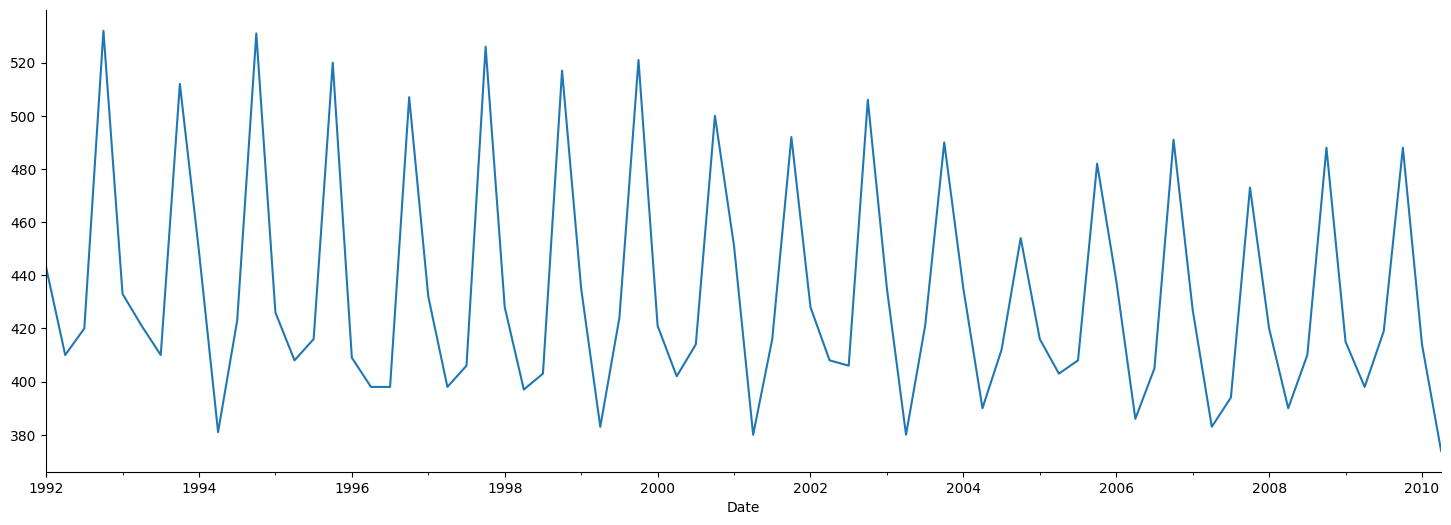

In [22]:
recent_production["Beer"].plot()

Below we are going to plot what we call lag-plot. Each graph shows $y_k$ plotted against $y_{t-k}$ for different values of $k$. The autocorrelations are the  correlations associated with  these scatterplots.

<center>
$r_1  = $Correlation$(y_t, y_{t−1})$
<center>
$r_2  = $Correlation$(y_t, y_{t−2})$

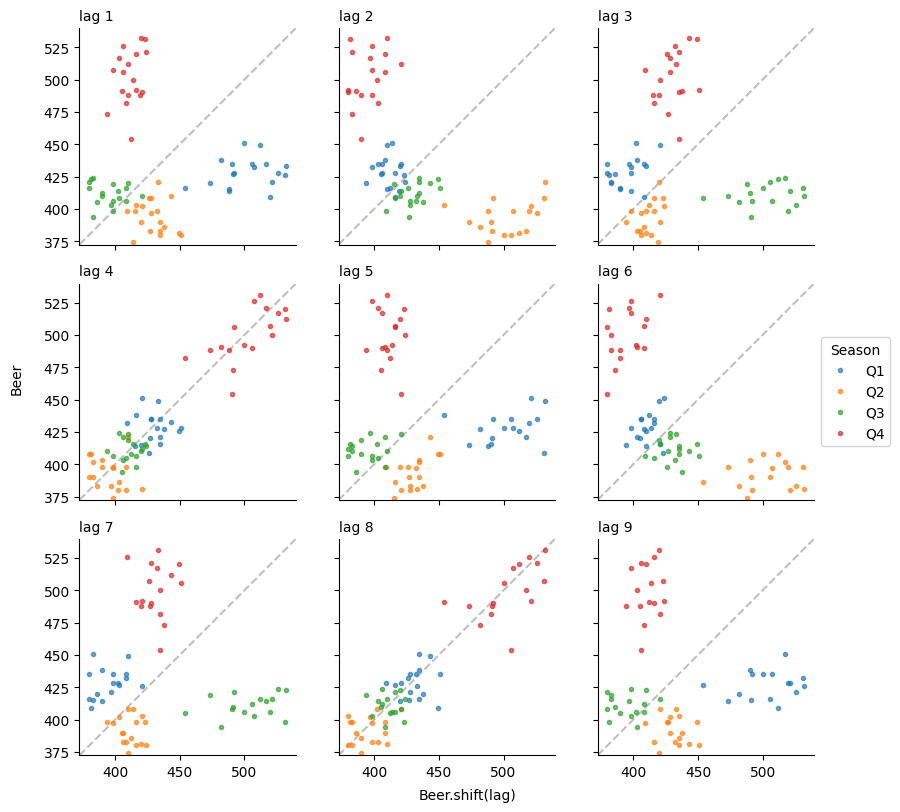

In [23]:
fig, axs = plt.subplots(3, 3, figsize=(9,8), sharex=True, sharey=True)
D = recent_production.copy()
D = pd.DataFrame({lag: D.Beer.shift(lag) for lag in range(10)})
D['q'] = recent_production.index.quarter
for (i, ax) in enumerate(axs.ravel()):
    for (q, d) in D.groupby('q'):
        ax.plot(d[i+1], d[0], '.', alpha=.66, label=f'Q{q}')
        lim = ax.get_xlim()
    ax.plot(lim, lim, 'k--', alpha=.25, zorder=-10)
    ax.set(xlim=lim, ylim=lim, title=f'lag {i+1}', aspect='equal')
axs.ravel()[5].legend(loc='center left', bbox_to_anchor=[1, .5], title='Season')
fig.text(.5, -.01, 'Beer.shift(lag)', ha='center', va='bottom')
fig.text(0, .5, 'Beer', ha='center', va='bottom', rotation=90)
plt.tight_layout()

### Autocorrelation

We denote the sample autocovariance at lag $k$ by $c_k$ and the sample autocorrelation at lag $k$ by $r_k$. Then we deﬁne:

$$
r_k = \frac{\sum\limits_{t=k+1}^{T} (y_t - \bar{y})(y_{t-k} - \bar{y})}{\sum\limits_{t=1}^{T} (y_t - \bar{y})^2}
$$


$r_1$ indicates how successive values of $y$ relate to each other <br>
$r_2$ indicates how $y$ values two periods apart relate to each other <br>
$r_k$ is almost the same as the sample correlation between $y_t$ and $y_{t−k}$<br>

### Autocorrelation plot (or corellogram)

When values $x_1, ..., x_n$ are obtained from a purely random process, then $r_1$, $r_2$, ... are expected to be independently distributed according to $\mathcal{N}(0, 1/n)$.

So, one way of testing if the series is purely random is to plot the sample autocorrelations. This plot is known as the Correlogram.

The correlogram plots $r_k$ against $k$. Obviously, $r_0$ is always 1. The bands correspond to 95% significance levels.

Let's look at the timeseries we imported in the beginning. We plot both the autocorrelation for the original timeseries (`alcohol.value`) and the `residual`, thus after removing the trend and the seasonality. 

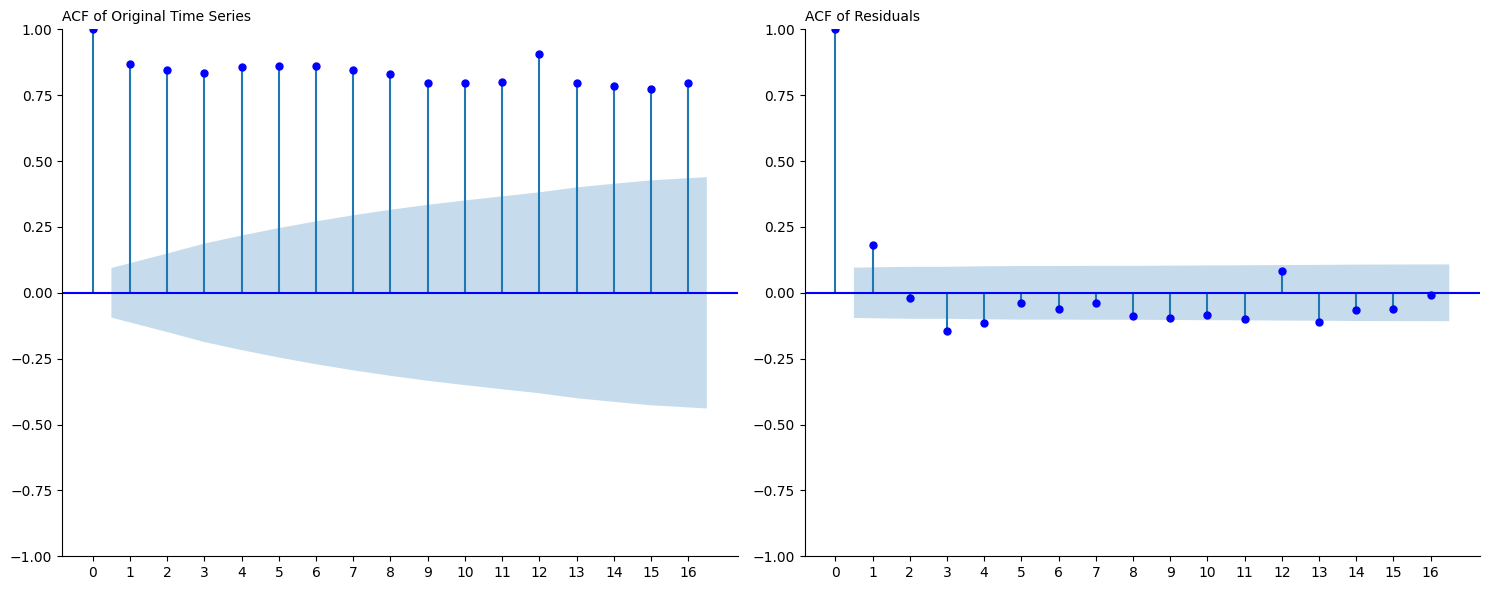

In [24]:
from statsmodels.graphics.tsaplots import plot_acf#, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # Create two subplots side by side

lags=16
# Plot ACF for original series
plot_acf(alcohol["value"], color="blue", lags=lags, ax=axes[0])
axes[0].set_xticks(range(0, lags+1, 1))  
axes[0].set_title("ACF of Original Time Series")

# Plot ACF for residuals
plot_acf(residual.dropna(), color="blue", lags=lags, ax=axes[1])
axes[1].set_xticks(range(0, lags+1, 1))  
axes[1].set_title("ACF of Residuals")

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

Let's see also the beer production example.

- $r_4$ is higher than for the other lags due to the seasonal pattern in the  data: peaks tend to be 4 quarters apart and troughs tend to be 4  quarters apart.
- $r_2$ is more negative than for the other lags because troughs tend to  be 2 quarters behind peaks.

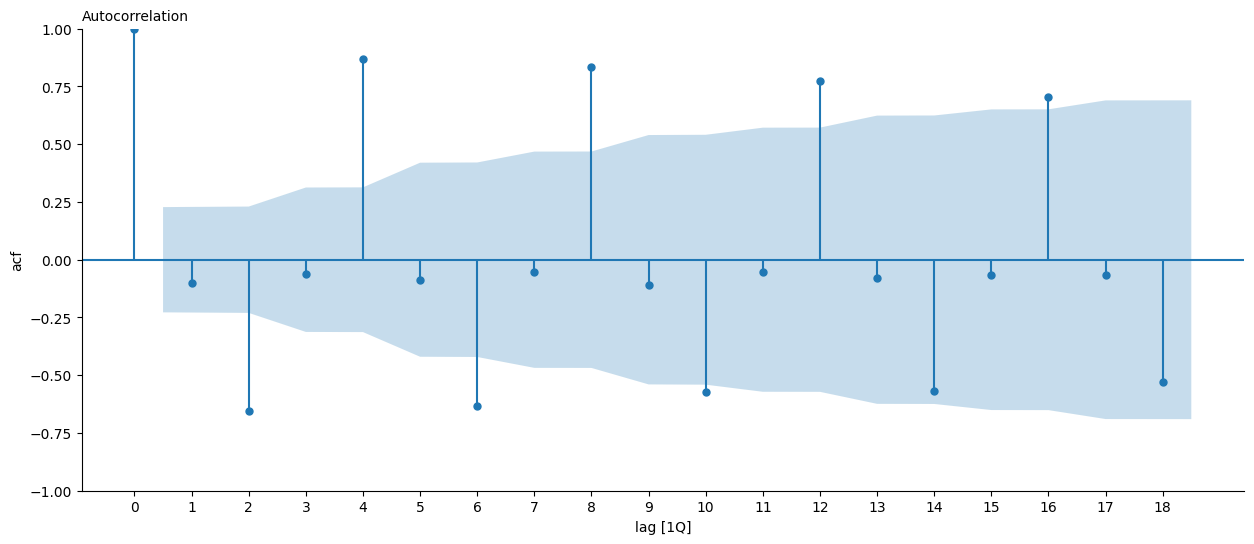

In [25]:
fig, ax = plt.subplots(figsize=(15,6))
sm.graphics.tsa.plot_acf(recent_production.Beer, ax=ax, lags=18)
ax.set(ylim=(-1,1), xlabel='lag [1Q]', ylabel='acf')
ax.set_xticks(range(0, 18+1, 1))  
plt.show()

Let's see two more examples of more extreme cases.

The following dataset contains monthly sunspot counts from 1749 till 1983, representing solar activity over time. 

There is a strong seasonality component (could be cyclic pattern as well). The strong seasonality, causes the ACF plot to exhibit asinusoidal pattern. This means that the values are cyclic, causing the autocorrelations to oscillate between positive and negative values.

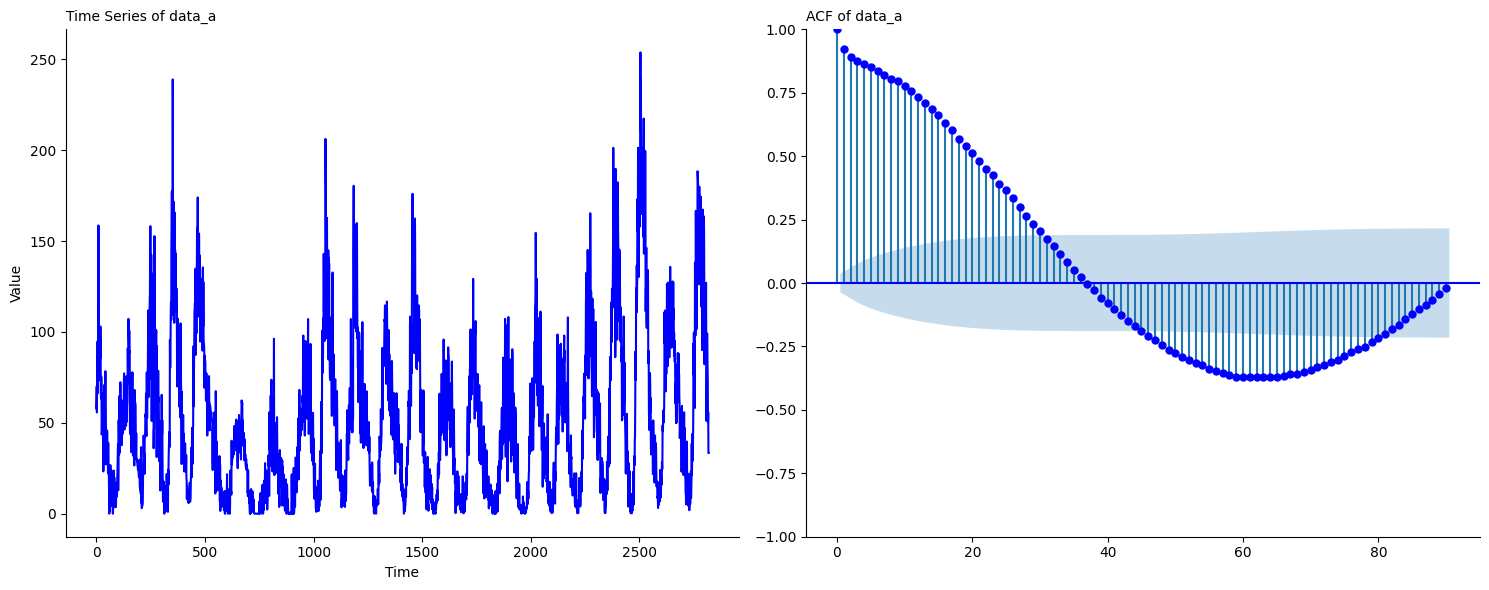

In [26]:
data = pd.read_csv('data/monthly-sunspots.txt').drop(['Month'],axis=1)#.head(100)
data_a = data.to_numpy().T[0]

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # 1 row, 2 columns

# Plot the time series in the first subplot
axes[0].plot(data_a, color="blue")
axes[0].set_title("Time Series of data_a")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Value")
# Plot the ACF in the second subplot
plot_acf(data_a, lags=90, color="blue", ax=axes[1])
axes[1].set_title("ACF of data_a")
plt.tight_layout()
plt.show()

The following dataset contains passenger volumes from 1949 till 1960. There is a strong trend which causes the ACF to decay very slowly. There is also a seasonality component which causes temporary peaks at the equivalent lags. 

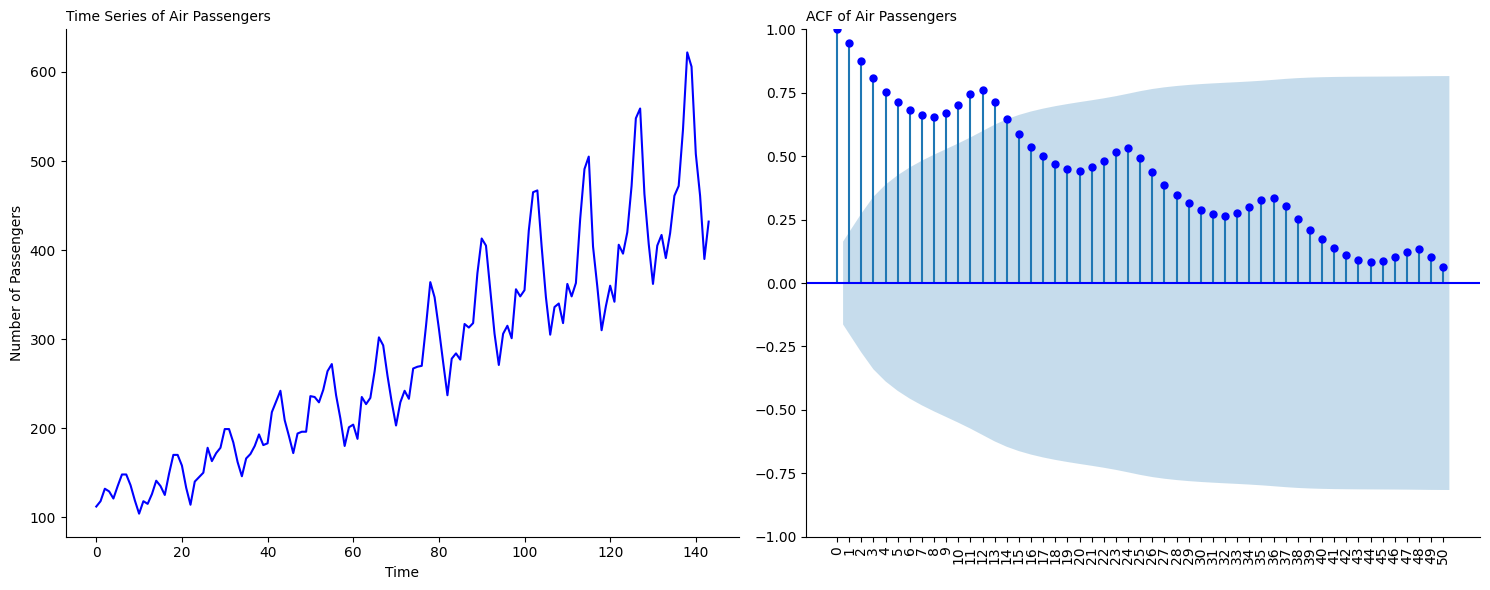

In [27]:
# Load the data
data = pd.read_csv('data/AirPassengers.csv').drop(['Month'], axis=1)  # .head(100) can be added if needed
data_b = data.to_numpy().T[0]

# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot the time series in the first subplot
axes[0].plot(data_b, color="blue")
axes[0].set_title("Time Series of Air Passengers")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Number of Passengers")

# Plot the ACF in the second subplot
plot_acf(data_b, lags=50, color="blue", ax=axes[1])
axes[1].set_xticks(range(0, 50+1, 1)) 
axes[1].set_title("ACF of Air Passengers")
#axes[1].grid()
plt.xticks(rotation=90)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

### Interpreting the ACF plot

+ When $x_1, ..., x_n$ are obtained from a purely random process, the probability that a fixed $r_k$ lies outside the bands equals 0.05.

+ A value of $r_k $outside the bands is significant i.e., it gives evidence against pure randomness. However, the overall probability of getting at least one $r_k$ outside the bands increases with the number of coefficients plotted, e.g. if 20 $r_k$ are plotted, one expects to get one significant value under pure randomness.

+ When data has a trend, the autocorrelations for small lags tend  to be large and positive. If the trend is strong, then the behavior expands to bigger lags.

+ When data are seasonal, the autocorrelations will be larger at the seasonal lags (i.e., at multiples of the seasonal frequency).

+ When data are trended and seasonal, you see a combination of  these eﬀects. We will see more examples next.

Allison Horst has a great visualization/motivation for explaing the ACF https://allisonhorst.com/time-series-acf



## 3. Stationarity

A stationary time series is one whose statistical properties do not depend on the time at which the series is observed.

Thus, time series with trends, or with seasonality, are not stationary — the trend and seasonality will affect the value of the time series at different times. On the other hand, a white noise series is stationary — it does not matter when you observe it, it should look much the same at any point in time.

Some cases can be confusing — a time series with cyclic behaviour (but with no trend or seasonality) is stationary. This is because the cycles are not of a fixed length, so before we observe the series we cannot be sure where the peaks and troughs of the cycles will be.

In general, a stationary time series will have no predictable patterns in the long-term. Time plots will show the series to be roughly horizontal (although some cyclic behaviour is possible), with constant variance.

### 3.1 Visual inspection

Formally, if ${y_t}$ is a stationary time series, then for all $s$, the distribution of $(y_t,...,y_{t+s})$ does not depend on $t$. Informally, a stationary time series is one whose properties do not depend on the time at which the series is observed.

A stationary series:
+ is roughly horizontal
+ has consntat variance
+ has no patterns predictable in the long-term

#### Stationary or not?

Below we see 9 timeseries. Which ones you think are stationary?

Next we see the timeseries with their ACF plots.

In [28]:
goog = pd.read_csv('data/gafa_stock.csv').query("Symbol == 'GOOG'")
goog = goog.set_index(pd.to_datetime(goog.Date, format='%Y-%m-%d'))

In [29]:
# strikes = pd.read_html('https://www.bls.gov/web/wkstp/annual-listing.htm', skiprows=1)[0]
strikes = pd.read_excel('data/strikes-annual-listing.xlsx', skiprows=2)
strikes = strikes.loc[:71, strikes.columns[:2]].astype(int)
strikes.columns = 'Year', 'Count'

In [30]:
#Housing prices in the US
housing = (
    pd.read_csv('data/enigma-us.gov_.census.eits_.ressales-'
                'e7513e56d76050c05caf638306055c98_1.csv')
    .query("dt_code == 'TOTAL' and cat_code == 'SOLD' and geo_desc == 'United States'")
    .rename(columns={'per_name':'date', 'val':'Count'})
    .pipe(compute, lambda x: dict(date = pd.to_datetime(x.date)))
    .set_index('date')
    [['Count']]
)

In [31]:
#Egg prices (we don't use the global economy one)

us_econ = pd.read_csv('data/global_economy.csv')
us_econ = (
    us_econ
    .query("Code == 'USA'")
    .assign(date=pd.to_datetime(us_econ.Year, format='%Y'))
    .set_index('date')
)

eggs = pd.read_csv('data/eggs.csv')
eggs.columns = 'date', 'EggPrice'
eggs = (
    eggs
    .set_index(pd.to_datetime(eggs.date))
    .join(us_econ.resample('1MS').max().fillna(method='ffill'))
)

In [32]:
#population of livestock in Australia over time
d = pd.read_csv('data/aus_livestock.csv')
vic_pigs = (
    d
    .assign(date = pd.to_datetime(d.Month, format='%Y %b'))
    .query("Animal == 'Pigs' and State == 'Victoria'")
    .groupby('date Animal'.split())
    .Count.sum().reset_index()
    .set_index('date')
)

In [33]:
#The Lynx Trapped dataset records the annual number of lynx trapped in Canada from 1821 to 1934

lynx = rdatasets.data('datasets', 'lynx')
lynx = (
    lynx
    .assign(date=pd.to_datetime(lynx.time, format='%Y'))
    .set_index('date')
)

In [34]:
#Australian beer production

d = pd.read_csv('data/aus_production.csv')
aus_production = (
    d
    .assign(Date=pd.to_datetime(d.Quarter.str.replace(' ', '')))
    .set_index('Date')
)
recent_production = aus_production.query("Date.dt.year >= 1992")

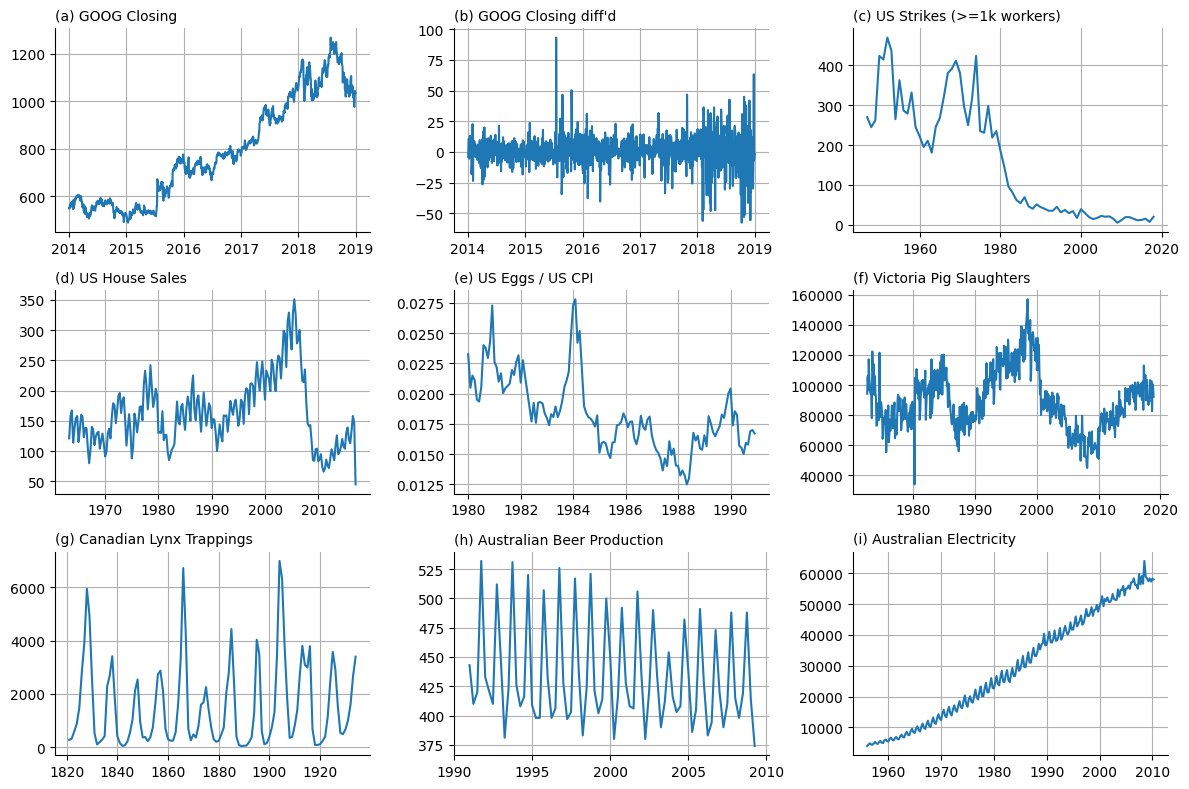

In [35]:
fig, axs = plt.subplots(3, 3, figsize=(12,8))
axs = axs.ravel()
d = goog
axs[0].plot(d.Close)
axs[1].plot(d.Close.diff())

d = strikes
axs[2].plot(d.Year, d.Count)

d = housing
axs[3].plot(d.resample('1q').sum().Count)

d = eggs
axs[4].plot((d.EggPrice / d.CPI).loc[:'1990'])

d = vic_pigs
axs[5].plot(d.Count)

d = lynx
axs[6].plot(d.value)

d = recent_production
axs[7].plot(d.Beer)

d = aus_production
axs[8].plot(d.Electricity)

titles = [
    'GOOG Closing',
    'GOOG Closing diff\'d',
    'US Strikes (>=1k workers)',
    'US House Sales',
    'US Eggs / US CPI',
    'Victoria Pig Slaughters',
    'Canadian Lynx Trappings',
    'Australian Beer Production',
    'Australian Electricity',
]

for (ax, title, letter) in zip(axs, titles, 'abcdefghi'):
    ax.set(title=f'({letter}) {title}')
    ax.grid(True)
xdate(axs[-2], '%Y', '5y')
plt.tight_layout()

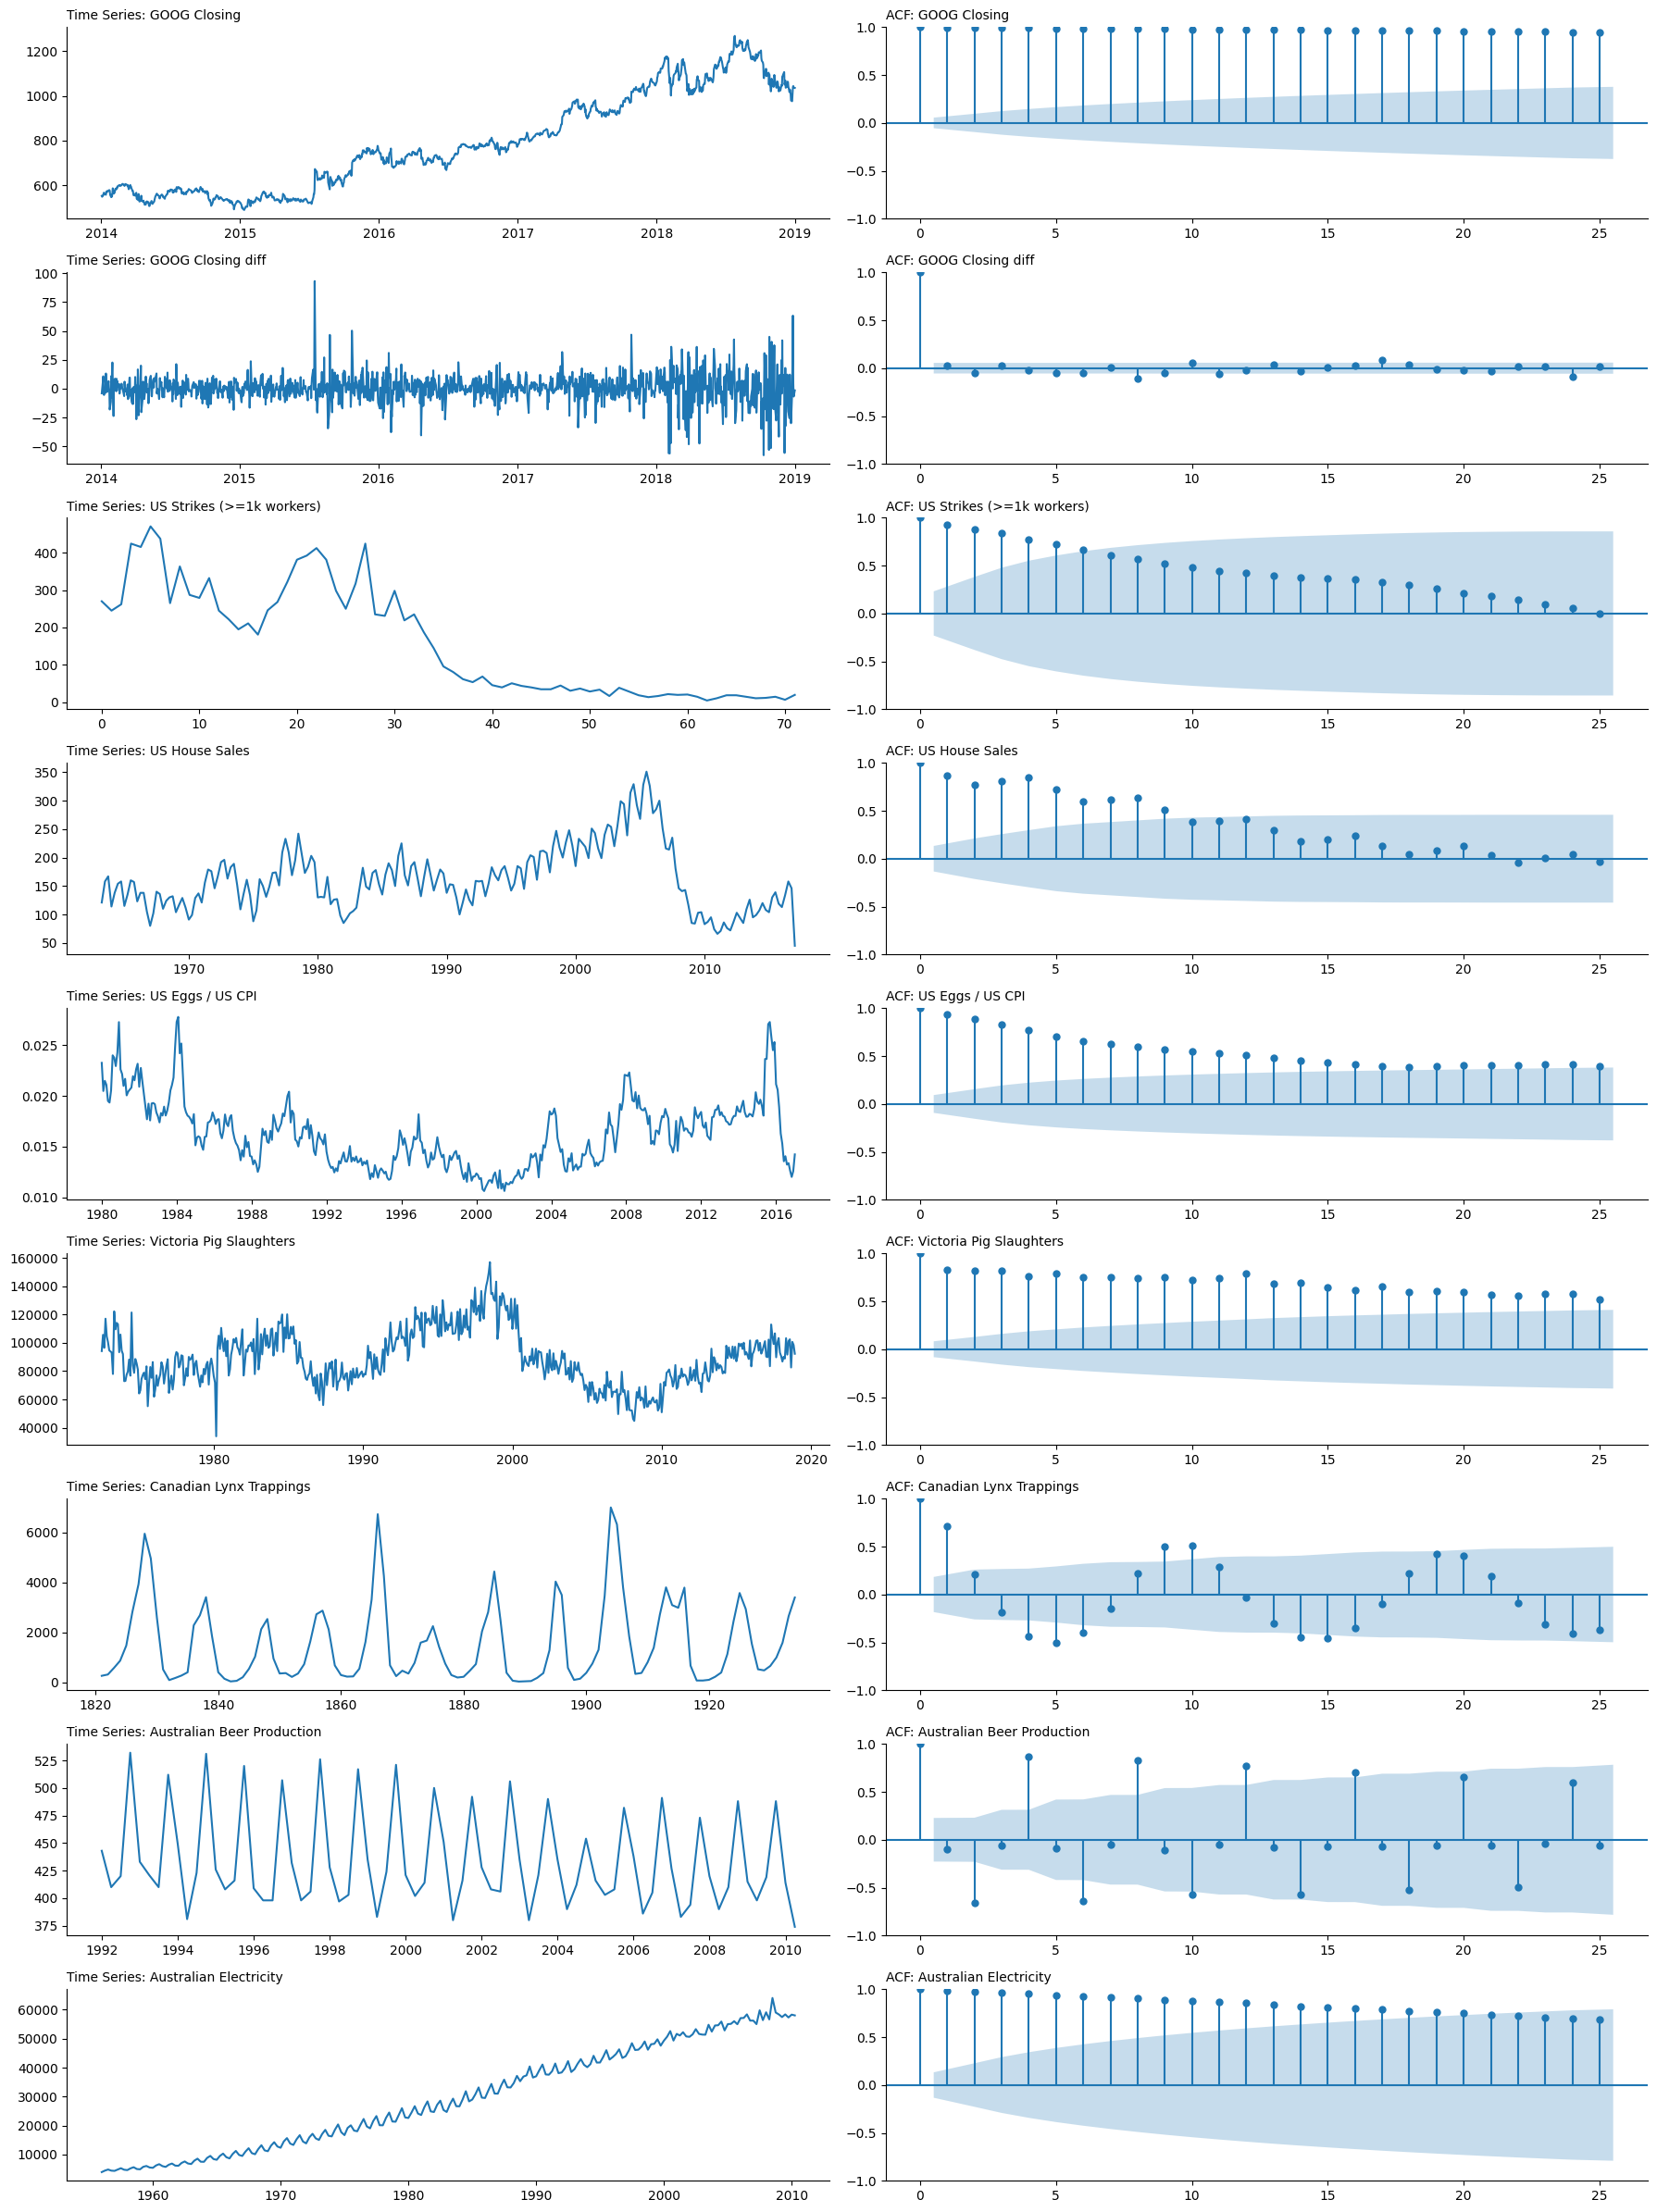

In [36]:
# Create a 9x2 subplot layout
fig, axs = plt.subplots(9, 2, figsize=(18, 24))
axs = axs.ravel()

# List of your timeseries data (replace these with actual data)
timeseries_data = [
    goog.Close, 
    goog.Close.diff().dropna(),
    strikes.Count, 
    housing.resample('1q').sum().Count, 
    (eggs.EggPrice / eggs.CPI).dropna(), 
    vic_pigs.Count,
    lynx.value,
    recent_production.Beer,
    aus_production.Electricity,
]

# Titles for each series
titles = [
    'GOOG Closing',
    'GOOG Closing diff',
    'US Strikes (>=1k workers)',
    'US House Sales',
    'US Eggs / US CPI',
    'Victoria Pig Slaughters',
    'Canadian Lynx Trappings',
    'Australian Beer Production',
    'Australian Electricity'
]

# Loop through each timeseries for plotting
for i, d in enumerate(timeseries_data):
    # Plot time series
    axs[2*i].plot(d)
    axs[2*i].set_title(f'Time Series: {titles[i]}')

    # Plot ACF
    sm.graphics.tsa.plot_acf(d, lags=25, ax=axs[2*i + 1])

    axs[2*i + 1].set_title(f'ACF: {titles[i]}')

# Adjust layout
plt.tight_layout()
plt.show()


### Identifying non-stationary series
- Visually inspect the time plot.

In the previous example, it's easy to rule out most options due to trends and seasonal effects. Plot (b) isstationary (because we took differences!) and plot (g) is also stationary because there is no seasonal but cyclic pattern. That is visible in the ACF plot (oscillates between positive/negative values).

- The ACF of stationary data drops to zero relatively quickly.
- The ACF of non-stationary data decreases slowly.
- For non-stationary data, the value of $r_1$ is often large and positive
- Also, statistical tests exist!

### What if a series is non-stationary?

- Transformations help to stabilize the variance.
- For timeseries modelling, we also need to stabilize the mean.


### 3.2 Statistical Tests

### a) Augmented Dickey-Fuller ([ADF](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test)) unit root test

The Augmented Dickey-Fuller test is used to test for a **unit root** in a time series sample. The presence of the unit root in time series make it non-stationary (has some time-dependent structure). The **null hypothesis** of the Augmented Dickey-Fuller is that there is a unit root, with **the alternative** that there is no unit root. 

#### Interpreting the Results

If the ADF statistic is greater than the critical value (available in the tables and returned by the function for significancy levels of 10%, 5% and 1%), then the null hypothesis is rejected, so the unit root is not present and the time series is stationary.

We can also look at the **p-value** returned by the test and compare it to the chosen level of significance. 

In [37]:
from statsmodels.tsa.stattools import adfuller

def is_stationary_with_adf(data, significance_level=0.05):
    """Decide if the given time series is stationary using ADF test."""
    test = adfuller(data, regression='c', autolag='BIC')
    p_value = test[1]
    print("ADF p-value: {:0.5f}".format(p_value))
    return p_value < significance_level

In [38]:
#First, we apply it on the alcohol dataset

significance_level = 0.05
print("Significance Level: {}%".format(100 * significance_level), '\n')

print("Stationary by ADF: {}".format(
    "yes" if is_stationary_with_adf(alcohol.value.values, significance_level) else "no"), '\n')

Significance Level: 5.0% 

ADF p-value: 0.70626
Stationary by ADF: no 



### b) Kwiatkowski-Phillips-Schmidt-Shin ([KPSS](http://www.statisticshowto.com/kpss-test/)) test for stationarity

The KPSS statistic checks if the timeseries is stationary around the mean (or the trend). The **null hypothesis** of the KPSS test is that the time series is trend stationary (stationary around the deterministic trend), the alternative that there is a unit root.

* Contrary to most unit root tests, the presence of a unit root is not the null hypothesis but the alternative.
* A major disadvantage for the KPSS test is that it has a high rate of Type I errors (it tends to reject the null hypothesis too often).
* One way to deal with the potential for high Type I errors is to combine the KPSS with an ADF test. If the result from both tests suggests that the time series in stationary, then it probably is.

#### Interpreting the Results

If the KPSS statistic is greater than the critical value (given in the table and returned by the function for significancy levels of 10%, 5%, 2.5% and 1%), then the null hypothesis is rejected, so the time series is non-stationary.

We can also look at the **p-value** returned by the test and compare it to the chosen level of significance.

The KPSS test results will provide the test statistic, p-value, and critical values. We interpret the results by comparing the test statistic to the critical values. If the test statistic exceeds the critical value, we reject the null hypothesis of stationarity around a deterministic trend, indicating non-stationarity. Otherwise, if the test statistic is below the critical value, we fail to reject the null hypothesis, suggesting stationarity around a deterministic trend.

In [39]:
from statsmodels.tsa.stattools import kpss

def is_stationary_with_kpss(data, significance_level=0.05):
    """Decide if the given time series is stationary using KPSS test."""
    test = kpss(data, regression='c')
    p_value = test[1]
    print("KPSS p-value: {:0.5f}".format(p_value))
    return p_value > significance_level

In [40]:
#First, we apply it on the alcohol dataset

significance_level = 0.05
print("Significance Level: {}%".format(100 * significance_level), '\n')

print("Stationary by ADF: {}".format(
    "yes" if is_stationary_with_adf(alcohol.value.values, significance_level) else "no"), '\n')

print("Stationary by KPSS: {}".format(
    "yes" if is_stationary_with_kpss(alcohol.value.values, significance_level) else "no"))

Significance Level: 5.0% 

ADF p-value: 0.70626
Stationary by ADF: no 

KPSS p-value: 0.01000
Stationary by KPSS: no


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




In [41]:
# List of letters for naming the time series
letters = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i']

# Iterate through each time series and apply both ADF and KPSS tests
for letter, ts in zip(letters, timeseries_data):
    # ADF Test
    adf_result = is_stationary_with_adf(ts, significance_level=0.05)
    print(f"Time Series {letter}: ADF - {'Stationary' if adf_result else 'Non-stationary'}")
    # KPSS Test
    kpss_result = is_stationary_with_kpss(ts, significance_level=0.05)
    print(f"Time Series {letter}: KPSS - {'Stationary' if kpss_result else 'Non-stationary'}")
    print("---")

ADF p-value: 0.77122
Time Series a: ADF - Non-stationary
KPSS p-value: 0.01000
Time Series a: KPSS - Non-stationary
---
ADF p-value: 0.00000
Time Series b: ADF - Stationary
KPSS p-value: 0.10000
Time Series b: KPSS - Stationary
---
ADF p-value: 0.57531
Time Series c: ADF - Non-stationary
KPSS p-value: 0.01000
Time Series c: KPSS - Non-stationary
---
ADF p-value: 0.11430
Time Series d: ADF - Non-stationary
KPSS p-value: 0.10000
Time Series d: KPSS - Stationary
---
ADF p-value: 0.00216
Time Series e: ADF - Stationary
KPSS p-value: 0.01843
Time Series e: KPSS - Non-stationary
---
ADF p-value: 0.10799
Time Series f: ADF - Non-stationary
KPSS p-value: 0.10000
Time Series f: KPSS - Stationary
---
ADF p-value: 0.00000
Time Series g: ADF - Stationary
KPSS p-value: 0.10000
Time Series g: KPSS - Stationary
---
ADF p-value: 0.47351
Time Series h: ADF - Non-stationary
KPSS p-value: 0.04070
Time Series h: KPSS - Non-stationary
---
ADF p-value: 0.98335
Time Series i: ADF - Non-stationary
KPSS p-valu

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning:

The test statistic

### 3.3 Stationarization

If a timeseries is not stationary, there are ways to correct it.

Techniques we can employ:
1. taking differences
1. transformations 
1. smoothing approaches (or filtering)
1. more complex parametric models (which we won't cover here)

### 3.2.1  Differencing

If we know that there is a trend but we cannot accurately estimate it, then one way to correct for the trend stationarity would be to try differencing (first-difference (FD) - differencing an observation from its prior observation).

We assume a series with an additive trend, but no seasonal variation. We can then write as : $x_t = m_t  + r_t$  . If we perfom differencing and assume a slowly-varying trend (such that $m_t \simeq m_{t+1}$) we obtain:

$$
y_t' = y_t - y_{t-1} \simeq r_t - r_{t-1}
$$

and then $y_t'$ (aka the difference) is stationary.

The seasonal growth, if present, can be corrected using a logarithmic transformation or seasonal differences.

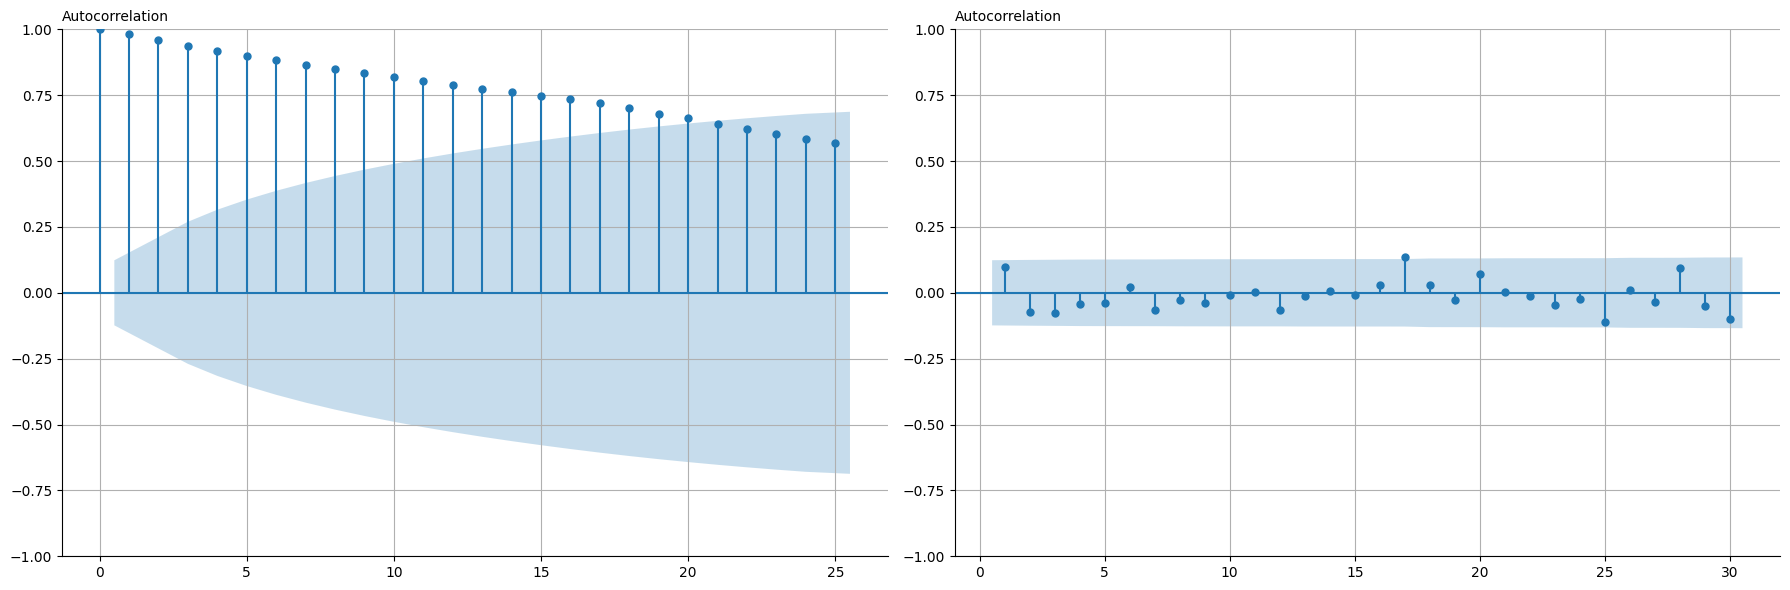

In [42]:
fig, (a1, a2) = plt.subplots(1, 2, figsize=(18,6))
d = g15 = goog['2015':'2015']
sm.graphics.tsa.plot_acf(d.Close, ax=a1)
sm.graphics.tsa.plot_acf(d.Close.diff().dropna(), lags=np.r_[1:31], ax=a2)
[ax.grid() for ax in (a1,a2)]
plt.tight_layout()

#### Seasonal differencing

A seasonal diﬀerence is the diﬀerence between an observation and the
corresponding observation from the previous year.

$y'_t = y_t - y_{t-m}$

where $m =$ number of seasons.

For monthly data $m = 12$.
For quarterly data $m = 4$.

Occasionally the diﬀerenced data will not appear stationary and it
may be necessary to diﬀerence the data a second time:

$$y_t'' = y'_t-y'_{t-1} = \\
=(y_t-y_{t-1}) - (y_{t-1}-y_{t-2}) = \\
=y_t-2y_{t-1}+y_{t-2}$$

In practice, it is almost never necessary to go beyond second-order diﬀerences.

#### Interpretation of differencing

+ First-order diﬀerences are the change between one observation and the next;

+ Seasonal diﬀerences show the change between e.g. one year to the next

### 3.2.2 Box-Cox Transformation 

Lets use the Box-Cox transformation to suppress some of the variance. This technique is used to transform non-normal dependent variables into a normal shape.

The Box-Cox transformation is a family of power transformations indexed by a parameter $\lambda$. Whenever you use it the parameter needs to be estimated from the data. The formal definition for a variable, say $x_t$ is as follows:

$$
w_t =
\begin{cases} \log (x_t) & \text{if} \lambda=0 \\
\frac{x_t^{\lambda}-1}{\lambda} & \text{otherwise}
\end{cases}
$$

If $\lambda=1$, then $w_t=x_t−1$, so the transformed data is shifted downwards but there is no change in the shape of the time series. But for all other values of $\lambda$, the time series will change shape. 

A good value of $\lambda$ is one which makes the size of the series variation about the same across the whole series, as that makes the forecasting model simpler.

After applying Box-Cox with a particular value of $\lambda$ the process might become stationary (because we reduce the variance). It is sometimes possible that even if after applying the Box-Cox transformation the series does not appear to be stationary. In that case, we need to rely on further modeling (see below).

<IPython.core.display.Javascript object>


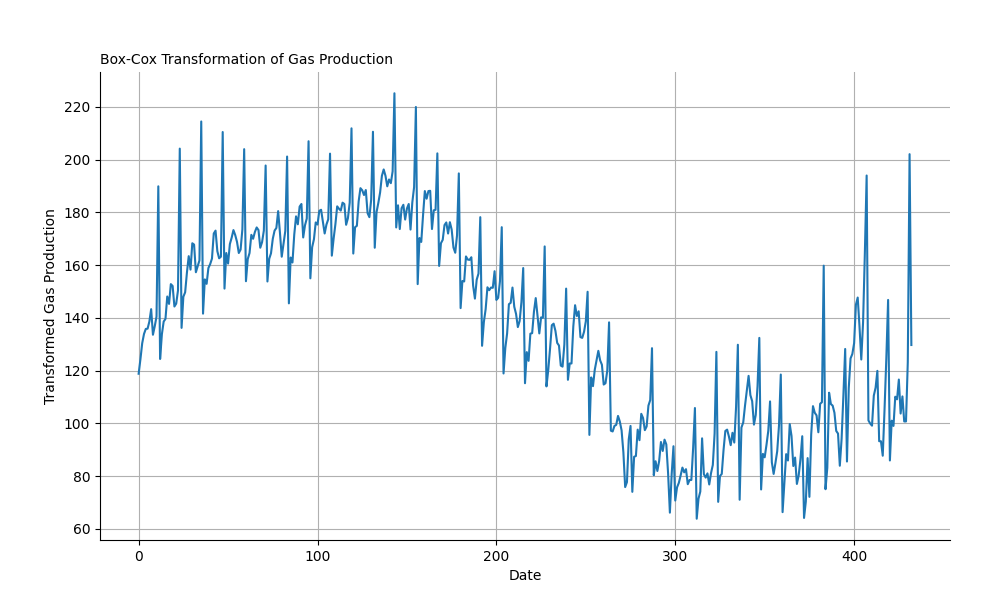

interactive(children=(FloatSlider(value=1.0, description='lam', max=2.0, min=-1.0), Output()), _dom_classes=('…

<function __main__.update(lam=1)>

In [74]:
# extra import for interactive plot!
from ipywidgets import interact

f = lambda lam: stats.boxcox(alcohol.value, lam)

#f = lambda lam: stats.boxcox(aus_production.Gas, lam)

%matplotlib notebook
# Create the plot initially (outside the function)
fig, ax = plt.subplots(figsize=(10, 6))

def update(lam=1):
    # Clear the current plot before updating
    ax.clear()
    
    # Plot the transformed data using the selected lambda
    ax.plot(alcohol.index, stats.boxcox(alcohol.value, lam))
    
    # Add the title, labels, and grid
    ax.set_title('Box-Cox Transformation of Gas Production')
    ax.set_xlabel('Date')
    ax.set_ylabel('Transformed Gas Production')
    ax.grid(True)
    
    # Adjust the layout to ensure everything fits well
    fig.subplots_adjust(left=.1, right=.95, bottom=.1)
    
    # Redraw the updated plot
    plt.draw()

# Interactively update the plot with the slider
interact(update, lam=(-1, 2, .1))


In [75]:
from scipy import stats
alcohol['boxcox'], lmbda = stats.boxcox(alcohol.value)

print("Stationary by ADF: {}".format(
    "yes" if is_stationary_with_adf(alcohol.boxcox.dropna().values, significance_level) else "no"), '\n')

print("Stationary by KPSS: {}".format(
    "yes" if is_stationary_with_kpss(alcohol.boxcox.dropna().values, significance_level) else "no"))

ADF p-value: 0.69765
Stationary by ADF: no 

KPSS p-value: 0.01000
Stationary by KPSS: no


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.




Since we have not yet achieved stationarity, we proceed to remove the overall trend using the first-difference (FD), i.e. take differences on the transformed timeseries and also remove the seasonality difference (SD) by assuming a 12 month seasonality effect.

In [76]:
alcohol["fd"] = alcohol.boxcox - alcohol.boxcox.shift(1)
alcohol["stationary"] = alcohol.fd - alcohol.fd.shift(seasons)
alcohol.head(20)

period  value      boxcox         fd  stationary  smooth
0  1988-01-01  119.8   71.549690        NaN         NaN     NaN
1  1988-02-01  125.3   74.429704   2.880014         NaN     NaN
2  1988-03-01  131.4   77.604095   3.174391         NaN     NaN
3  1988-04-01  134.9   79.416473   1.812379         NaN     NaN
4  1988-05-01  136.8   80.397679   0.981206         NaN     NaN
5  1988-06-01  136.9   80.449271   0.051591         NaN     NaN
6  1988-07-01  139.6   81.840336   1.391065         NaN     NaN
7  1988-08-01  144.3   84.253241   2.412905         NaN     NaN
8  1988-09-01  134.6   79.261377  -4.991864         NaN     NaN
9  1988-10-01  137.8   80.913366   1.651989         NaN     NaN
10 1988-11-01  141.5   82.817061   1.903696         NaN     NaN
11 1988-12-01  190.9  107.659619  24.842557         NaN     NaN
12 1989-01-01  125.4   74.481908 -33.177710         NaN     NaN
13 1989-02-01  134.8   79.364780   4.882871    2.002857     NaN
14 1989-03-01  139.6   81.840336   2.475556   -0.698835     NaN
15 1989-04-01  140.6   82.354623   0.514288   -1.298091     NaN
16 1989-05-01  149.1   86.706595   4.351972    3.370766     NaN
17 1989-06-01  146.3   85.276786  -1.429809   -1.481401     NaN
18 1989-07-01  153.8   89.098559   3.821773    2.430708     NaN
19 1989-08-01  153.1   88.742939  -0.355620   -2.768525     NaN

In [77]:
print("Stationary by ADF: {}".format(
    "yes" if is_stationary_with_adf(alcohol.stationary.dropna().values, significance_level) else "no"), '\n')

print("Stationary by KPSS: {}".format(
    "yes" if is_stationary_with_kpss(alcohol.stationary.dropna().values, significance_level) else "no"))

ADF p-value: 0.00000
Stationary by ADF: yes 

KPSS p-value: 0.10000
Stationary by KPSS: yes


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




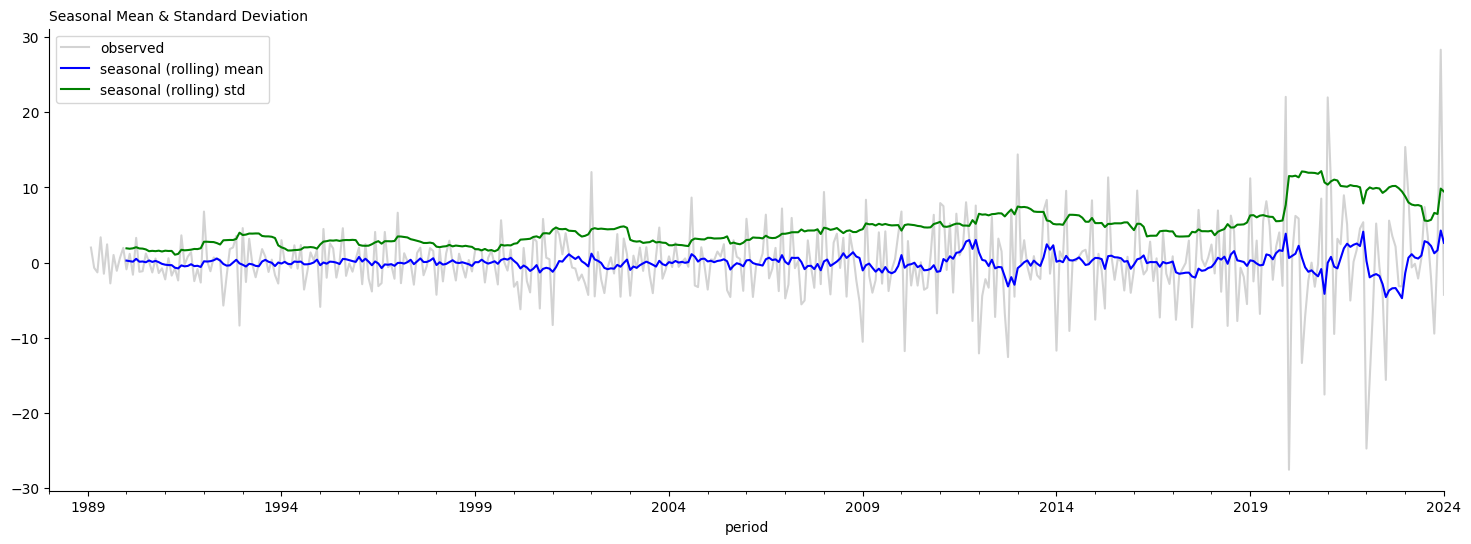

In [80]:
%matplotlib inline
visual_check(alcohol, "stationary", seasons)

### 3.2.3 Smoothing (or Moving averages)

Here we repeat the definition.

For a time series $x_t$, the *$q$-day moving average at time $t$*, denoted $MA^q_t$, is the average of $x_t$ over the past $q$ days, 

$$
MA^q_t = \frac{1}{q} \sum_{i = 0}^{q-1} x_{t - i}
$$


In [81]:
alcohol["smooth"] = alcohol["stationary"].rolling(window = 15, center = False).mean()
alcohol.tail()

period  value      boxcox         fd  stationary    smooth
428 2023-09-01  101.7   61.940323  -5.069928   -2.074191  1.335974
429 2023-10-01  101.7   61.940323   0.000000   -9.452469  1.746712
430 2023-11-01  124.2   73.855086  11.914762    1.677928  1.485961
431 2023-12-01  203.1  113.652833  39.797747   28.340839  3.139341
432 2024-01-01  130.7   77.240845 -36.411988   -4.279986  2.711075

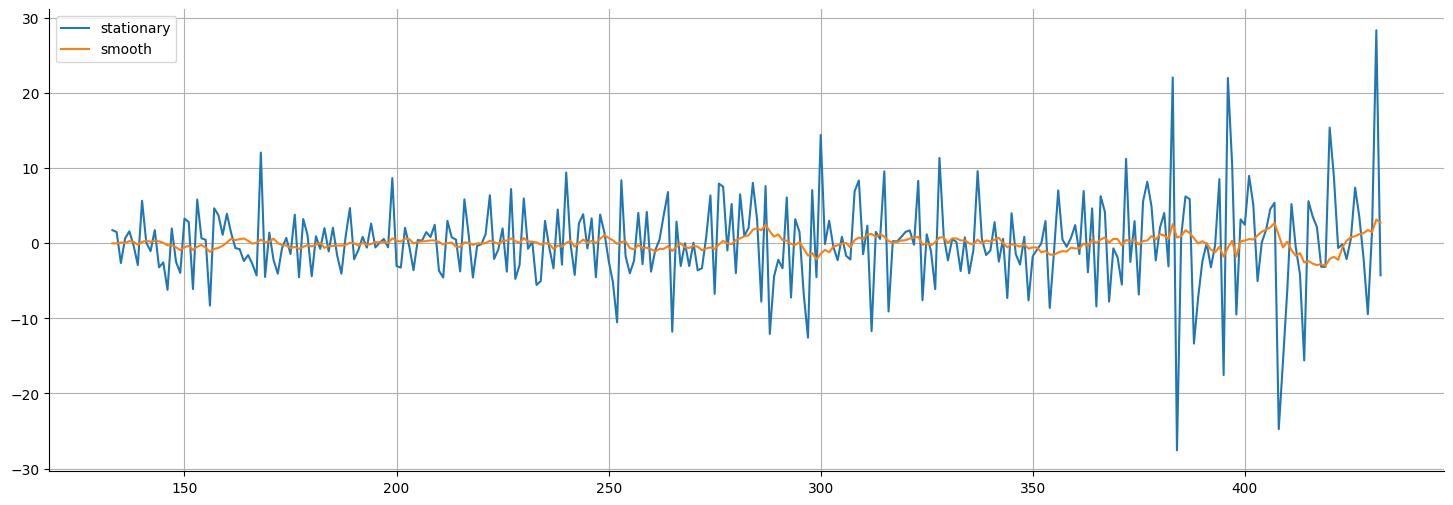

In [82]:
alcohol[["stationary", "smooth"]].tail(300).plot(grid = True); 

<img src="img/wooclap.png" alt="wooclap" width="40%">

### POLL:

If I increase the smoothing window, I get more details about the micro-changes in the timeseries. True of False?

## 4. Modeling ways: Autoregression & Moving Average models

We will first describe two ways of modeling a timeseries based on its past (AR and MA) and then see how we can combine them in ARIMA models.

### 4.1 Autoregression

We now move to ask whether the next value in the time series can be predicted as some function of its previous values.

In an autoregression model, we forecast the variable of interest using a linear combination of past values of the variable. The term autoregression indicates that it is a regression of the variable against itself (lagged values).

Thus, an autoregressive model of order $p$ can be written as

$$
y_t = c + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \dots + \phi_p y_{t-p} + \epsilon_t
$$

where $\epsilon_t$ is white noise. 

This is like a multiple regression but with lagged values of $y_t$ as predictors. We refer to this as an $AR(p)$ model, an autoregressive model of order $p$.

Autoregressive models are remarkably flexible at handling a wide range of different time series patterns

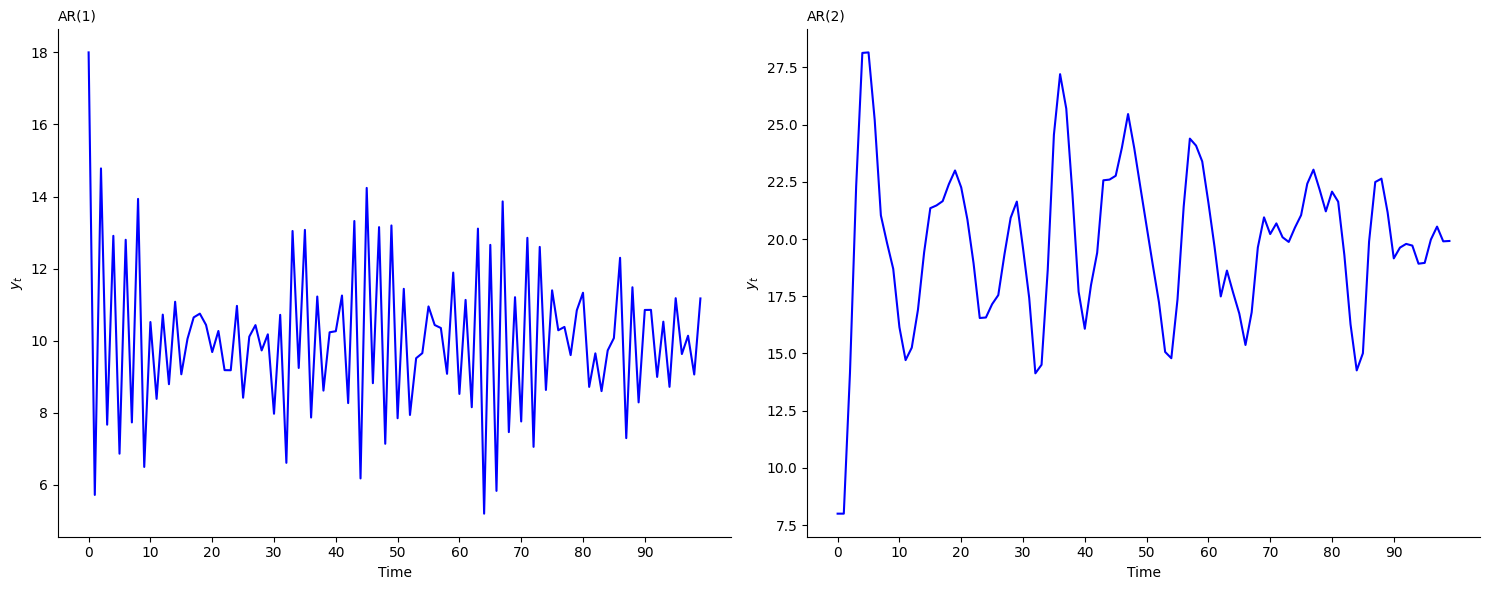

In [83]:
# Generate the AR(1) model: y_t = 18 - 0.8 * y_(t-1) + epsilon_t
n = 100
epsilon = np.random.normal(loc=0, scale=1, size=n)
y_ar1 = np.zeros(n)
y_ar1[0] = 18  # initial condition

for t in range(1, n):
    y_ar1[t] = 18 - 0.8 * y_ar1[t-1] + epsilon[t]

# Generate the AR(2) model: y_t = 8 + 1.3 * y_(t-1) - 0.7 * y_(t-2) + epsilon_t
y_ar2 = np.zeros(n)
y_ar2[0] = 8  # initial condition
y_ar2[1] = 8  # initial condition for AR(2)

for t in range(2, n):
    y_ar2[t] = 8 + 1.3 * y_ar2[t-1] - 0.7 * y_ar2[t-2] + epsilon[t]

# Plot the two models side by side
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Plot AR(1)
ax[0].plot(y_ar1, color="blue")
ax[0].set_title("AR(1)")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("$y_t$")
ax[0].set_xticks(np.arange(0, n, step=10))  # Set x-ticks at every 10th point
ax[0].set_xticklabels(np.arange(0, n, step=10))  # Label the ticks accordingly

# Plot AR(2)
ax[1].plot(y_ar2, color="blue")
ax[1].set_title("AR(2)")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("$y_t$")
ax[1].set_xticks(np.arange(0, n, step=10))  # Set x-ticks at every 10th point
ax[1].set_xticklabels(np.arange(0, n, step=10))  # Label the ticks accordingly

plt.tight_layout()
plt.show()


AR(1) model is: $y_t = 18 - 0.8 \times y_{t-1} + \epsilon_t$

AR(2) model is: $y_t = 8 + 1.3 \times y_{t-1} -0.7 \times y_{t-2}+ \epsilon_t$

In both cases, $\epsilon_t$ is normally distributed white noise with mean zero and variance one.


For an AR(1) model:

- When $ \phi_1 = 0 $ and $ c = 0 $, $ y_t $ is equivalent to white noise;
- When $ \phi_1 = 1 $ and $ c = 0 $, $ y_t $ is equivalent to a random walk;
- When $ \phi_1 = 1 $ and $ c \neq 0 $, $ y_t $ is equivalent to a random walk with drift (intercept);
- When $ \phi_1 < 0 $, $ y_t $ tends to oscillate around the mean.

We normally restrict autoregressive models to stationary data, in which case some constraints on the values of the parameters are required.

For an AR(1) model:  
$$
-1 < \phi_1 < 1
$$
For an AR(2) model:  
$$
-1 < \phi_2 < 1, \quad \phi_1 + \phi_2 < 1, \quad \phi_2 - \phi_1 < 1
$$

For higher order ($p>=3$) these conditions become more tricky.

### 4.2 Moving average models

Rather than using past values of the forecast variable in a regression, a moving average model uses past forecast errors in a regression-like model:

$$
y_t = c + \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \dots + \theta_q \epsilon_{t-q}
$$

where $ \epsilon_t $ is white noise. We refer to this as an $MA(q)$ model, a moving average model of order $ q $. Of course, we do not observe the values of $ \epsilon_t $, so it is not really a regression in the usual sense.

Notice that each value of $ y_t $ can be thought of as a weighted moving average of the past few forecast errors (although the coefficients will not normally sum to one). However, moving average models should not be confused with the moving average smoothing. A moving average model is used for forecasting future values, while moving average smoothing is used for estimating the trend-cycle of past values.


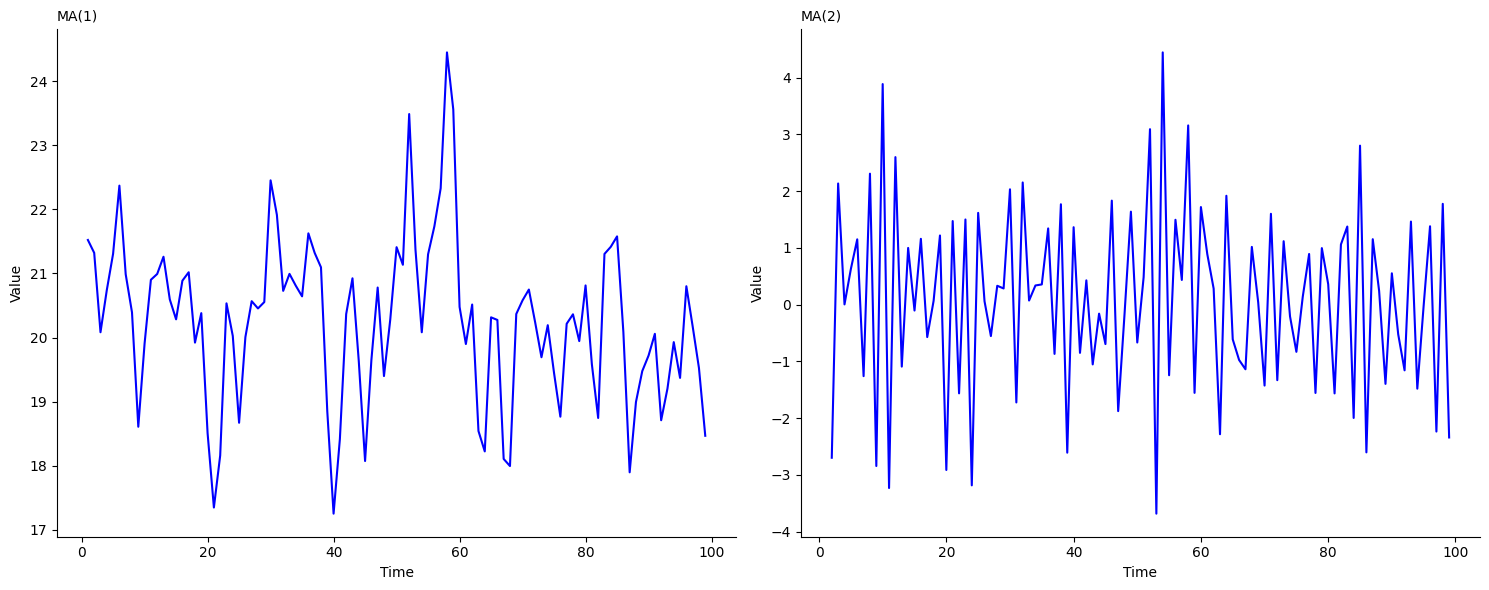

In [84]:
# Define the length of the time series
n = 100

# Generate white noise for the MA models
epsilon = np.random.normal(loc=0, scale=1, size=n)

# MA(1) model: y_t = 20 + epsilon_t + 0.8 * epsilon_t-1
ma1 = 20 + epsilon[1:] + 0.8 * epsilon[:-1]

# MA(2) model: y_t = epsilon_t - epsilon_t-1 + 0.8 * epsilon_t-2
ma2 = epsilon[2:] - epsilon[1:-1] + 0.8 * epsilon[:-2]

# Plot the results side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot MA(1) on the left
axes[0].plot(range(1, n), ma1, color="blue")
axes[0].set_title("MA(1)")
axes[0].set_xlabel("Time")
axes[0].set_ylabel("Value")

# Plot MA(2) on the right
axes[1].plot(range(2, n), ma2, color="blue")
axes[1].set_title("MA(2)")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Value")

plt.tight_layout()
plt.show()


MA(1) is $y_t = 20 + \epsilon_t + 0.8 \epsilon_{t-1}$  
MA(2) is $y_t = \epsilon_t - \epsilon_{t-1} + 0.8 \epsilon_{t-2}$  

In both cases, $ \epsilon_t $ is normally distributed white noise with mean zero and variance one.

Changing the parameters $ \theta_1, \dots, \theta_q $ results in different time series patterns. As with autoregressive models, the variance of the error term $ \epsilon_t $ will only change the scale of the series, not the patterns.

Any stationary AR(p) model can be written as an MA(∞) model. 
The reverse is true for invertible MA(q) models. Invertibility holds when $|\theta_1| < 1$ to ensure recent observations have more weight than distant ones.

The invertibility constraints for other models are:

- MA(1): $-1 < \theta_1 < 1$
- MA(2): $-1 < \theta_2 < 1$, $\theta_2 + \theta_1 > -1$, $\theta_1 - \theta_2 < 1$

For $q \geq 3$, more complex conditions apply.


### 4.3 ARIMA models

If we combine differencing with autoregression and a moving average model, we obtain a non-seasonal ARIMA model. ARIMA is an acronym for AutoRegressive Integrated Moving Average (in this context, "integration" is the reverse of differencing). The full model can be written as:

$$
y'_t = c + \phi_1 y'_{t-1} + \dots + \phi_p y'_{t-p} + \\
\theta_1 \epsilon_{t-1} + \dots + \theta_q \epsilon_{t-q} + \epsilon_t
$$

where $y'_t$ is the differenced series (it may have been differenced more than once). The "predictors" include both lagged values of $y_t$ and lagged errors. We call this an ARIMA($p, d, q$) model, where:

- $p$ = order of the autoregressive part;
- $d$ = degree of first differencing involved;
- $q$ = order of the moving average part.

The same stationarity and invertibility conditions that are used for autoregressive and moving average models also apply to an ARIMA model.

#### Special cases of ARIMA models.

| Model Type               | ARIMA Model              |
|--------------------------|--------------------------|
| White noise              | ARIMA(0,0,0) with no constant |
| Random walk              | ARIMA(0,1,0) with no constant |
| Random walk with drift   | ARIMA(0,1,0) with a constant |
| Autoregression           | ARIMA(p, 0, 0)     |
| Moving average           | ARIMA(0, 0, q)     |


Let's see an example. We use the more general SARIMAX model (see documentation [here](https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html) and some more examples [here](https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html)). 

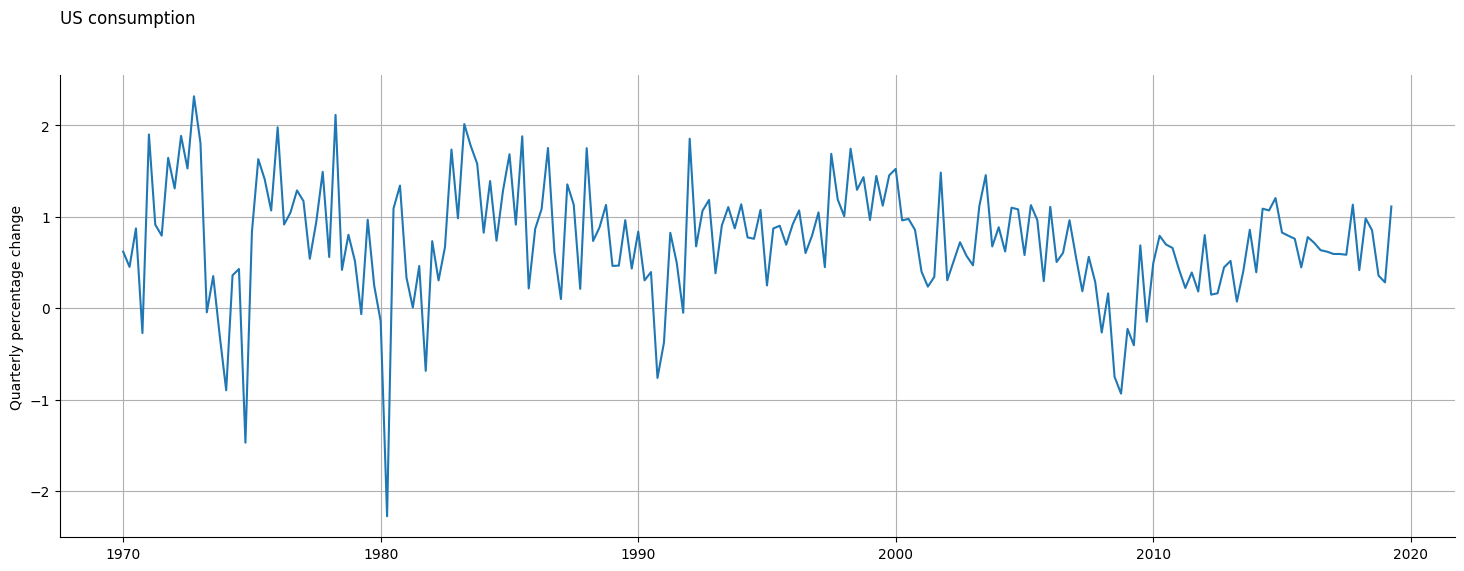

In [88]:
us_change = pd.read_csv('data/us_change.csv')
us_change = (
    us_change
    .assign(date=pd.to_datetime(us_change.Quarter.str.replace(' ', '')))
    .set_index('date')
    .pipe(set_freq)
)

fig, ax = plt.subplots()
ax.plot(us_change.Consumption)
ax.set(ylabel='Quarterly percentage change')
suptitle('US consumption')
ax.grid()

In [87]:
fit = sm.tsa.SARIMAX(us_change.Consumption, order=(3, 0, 1), trend='c').fit(disp=0)
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Consumption   No. Observations:                  198
Model:               SARIMAX(3, 0, 1)   Log Likelihood                -170.046
Date:                Thu, 27 Feb 2025   AIC                            352.091
Time:                        11:58:04   BIC                            371.821
Sample:                    01-01-1970   HQIC                           360.077
                         - 04-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3663      0.119      3.071      0.002       0.133       0.600
ar.L1          0.0432      0.253      0.171      0.864      -0.452       0.538
ar.L2          0.2000      0.082      2.436      0.015       0.039       0.361
ar.L3          0.2624      0.079      3.338      0.001       0.108       0.416
ma.L1          0.1681      0.257      0.654      0.513      -0.336       0.672
sigma2         0.3256      0.023     14.376      0.000       0.281       0.370
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                80.06
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.22   Skew:                            -0.57
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

This looks like any other regression problem! In fact, since this is a ARIMA(1,0,3), the equation can be written as:

$$
y_t = 0.3663 + 0.0432 y_{t-1} + 0.2 y_{t-2} + 0.2624 y_{t-3} + 0.1681 \epsilon_{t-1} + \epsilon_t
$$

where $\epsilon_t$ is white noise with a standard deviation of 0.57 = $\sqrt{0.3256}$.


We can also use the usual regression residual diagnostics. More specifically for a good fit the expecations are as follows:

+ Residual values: The residuals should be randomly scattered around zero, with no discernible pattern or trend.

+ Histogram of Residuals: The residuals should be approximately normally distributed, with the histogram resembling a bell curve. This indicates that the residuals do not exhibit any skewness or extreme outliers.

+ [Normal Q-Q plot](https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot): The points should closely follow the diagonal line, indicating that the residuals are normally distributed. Deviations from the line suggest non-normality in the residuals.

+ ACF of Residuals: The autocorrelation function (ACF) plot should show no significant spikes, meaning the residuals are uncorrelated. This suggests that the model has accounted for all time series dependencies.

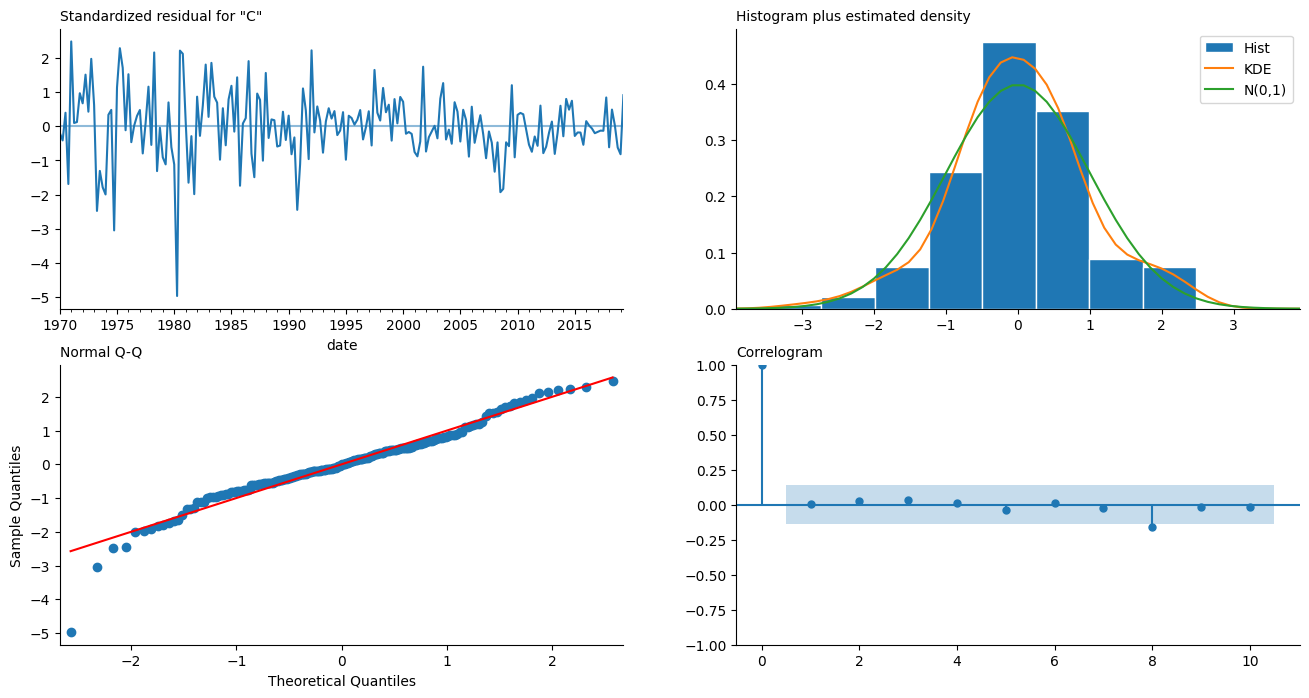

In [89]:
# Residual diagnostics plots
fit.plot_diagnostics(figsize=(16, 8))
plt.show()

We can also use the model for forecasting future values. For now we just see the forecast and later on we will see how to evaluate it.

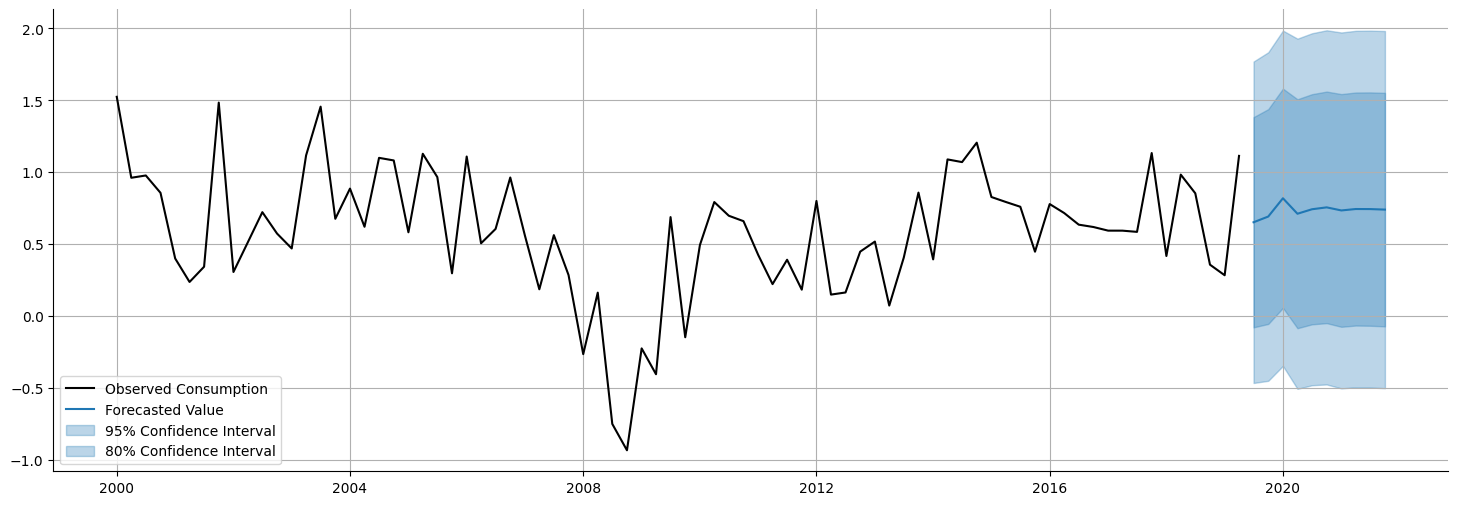

In [90]:
fig, ax = plt.subplots()
ax.plot(us_change['2000':].Consumption, 'k', label='Observed Consumption')

fc = fit.get_forecast(10)
ax.plot(fc.predicted_mean, label='Forecasted Value')
ci = ciclean(fc.conf_int())
ax.fill_between(fc.predicted_mean.index, ci.lower, ci.upper, color='C0', alpha=.3, label='95% Confidence Interval')
ci = ciclean(fc.conf_int(alpha=.2))
ax.fill_between(fc.predicted_mean.index, ci.lower, ci.upper, color='C0', alpha=.3, label='80% Confidence Interval')

ax.grid()
ax.legend(loc=3)

### Understanding ARIMA models: Long-term forecasts

$$
y'_t = c + \phi_1 y'_{t-1} + \dots + \phi_p y'_{t-p} + \\
\theta_1 \epsilon_{t-1} + \dots + \theta_q \epsilon_{t-q} + \epsilon_t
$$

The constant $c$ has an important effect on the long-term forecasts obtained from these models.

- If $c = 0$ and $d = 0$, the long-term forecasts will go to zero.
- If $c = 0$ and $d = 1$, the long-term forecasts will go to a non-zero constant.
- If $c = 0$ and $d = 2$, the long-term forecasts will follow a straight line.
- If $c \neq 0$ and $d = 0$, the long-term forecasts will go to the mean of the data.
- If $c \neq 0$ and $d = 1$, the long-term forecasts will follow a straight line.
- If $c \neq 0$ and $d = 2$, the long-term forecasts will follow a quadratic trend (not recommended and probably the model won't converge).
<br><br>
- The higher the value of $d$, the more rapidly the prediction intervals increase in size.
- For $d=0$, the long-term forecast standard deviation will go to the standard deviation of the historical data, so all predictions will essentially be the same.

### Understanding ARIMA models: Partial Autocorrelation Plot (PACF + ACF = 👦👧)

It is usually not possible to tell, simply from a time plot, what values of $p$ and $q$ are appropriate for the data. However, it is sometimes possible to use the ACF plot, and the closely related PACF plot, to determine appropriate values for $p$ and $q$.

Recall that an ACF plot shows the autocorrelations which measure the relationship between $y_t$ and $y_{t-k}$ for different values of $k$. Now if $y_t$ and $y_{t-1}$ are correlated, then $y_{t-1}$ and $y_{t-2}$ must also be correlated. However, then $y_t$ and $y_{t-2}$ might be correlated, simply because they are both connected to $y_{t-1}$, rather than because of any new information contained in $y_{t-2}$ that could be used in forecasting $y_t$.

To overcome this problem, we can use partial autocorrelations. These measure the relationship between $y_t$ and $y_{t-k}$ after removing the effects of lags $1, 2, 3, \dots, k-1$.

+ The first partial autocorrelation is identical to the first autocorrelation, because there is nothing between them to remove.
+ Each partial autocorrelation can be estimated as the last coefficient in an autoregressive model. Specifically, $\alpha_k$, the $k$th partial autocorrelation coefficient, is equal to the estimate of $\phi_k$ in an AR($k$) model.

In practice, there are more efficient algorithms for computing $\alpha_k$ than fitting all of these autoregressions, but they give the same results.


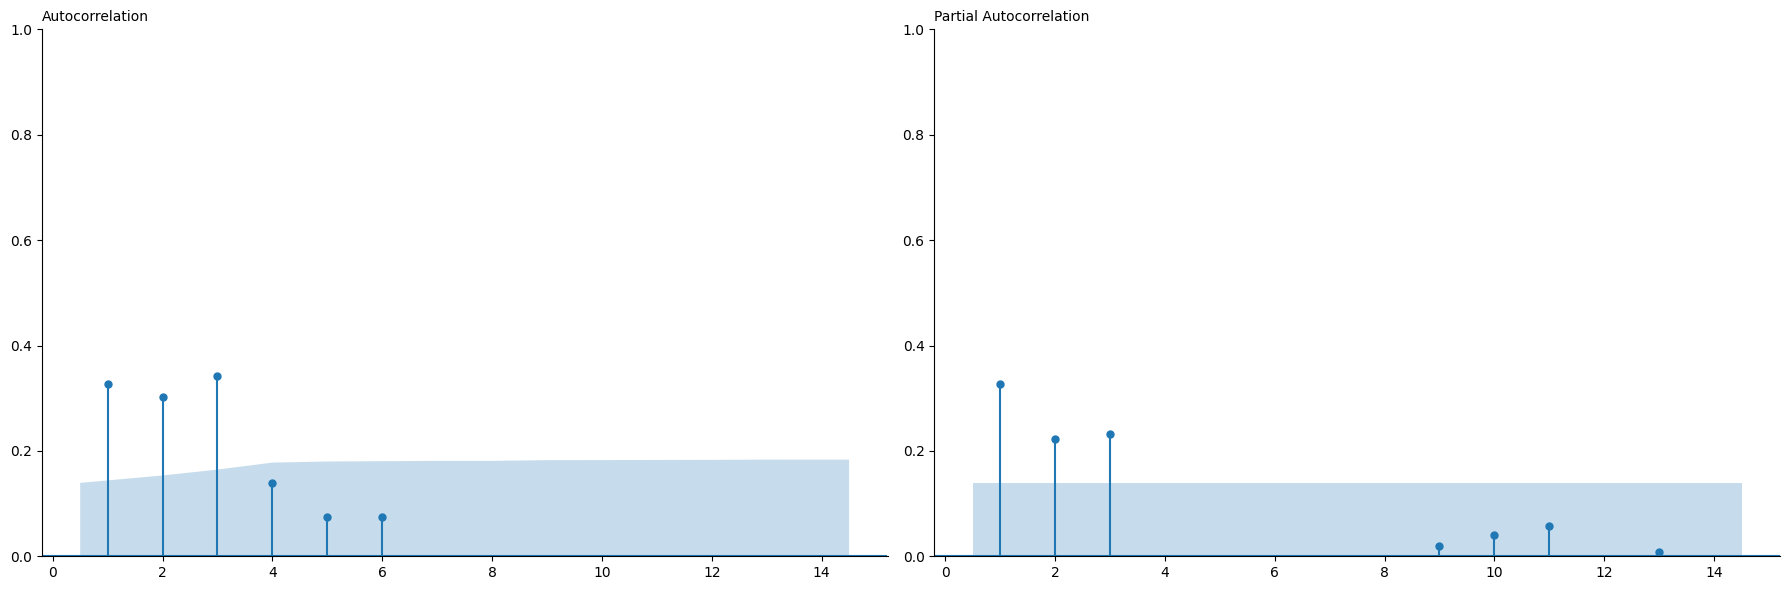

In [91]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6))  # 1 row, 2 columns
lags = np.r_[1:15]
sm.graphics.tsa.plot_acf(us_change.Consumption, lags=lags, ax=axs[0])
sm.graphics.tsa.plot_pacf(us_change.Consumption, lags=lags, ax=axs[1])

# Set y-axis to start from 0
for ax in axs:
    ax.set_ylim(bottom=0)

plt.tight_layout()

If the data are from an ARIMA($p$, $d$, 0) or ARIMA(0, $d$, $q$) model, then the ACF and PACF plots can be helpful in determining the value of $p$ or $q$. If $p$ and $q$ are both positive, then the plots do not help (much) in finding suitable values for $p$ and $q$.


The data may follow an ARIMA($p$, $d$, 0) model if the ACF and PACF plots of the differenced data show the following patterns:

- The ACF is exponentially decaying or sinusoidal.
- There is a significant spike at lag $p$ in the PACF, but none beyond lag $p$.

The data may follow an ARIMA(0, $d$, $q$) model if the ACF and PACF plots of the differenced data show the following patterns:

- The PACF is exponentially decaying or sinusoidal.
- There is a significant spike at lag $q$ in the ACF, but none beyond lag $q$.

More info about how to select our model can be found [here](https://people.duke.edu/~rnau/arimrule.htm). Otherwise, we can use cross-validation to determine optimal values for the parameters.

Let's revisit the initial 9 timeseries we had and see their ACF/PACF plots.

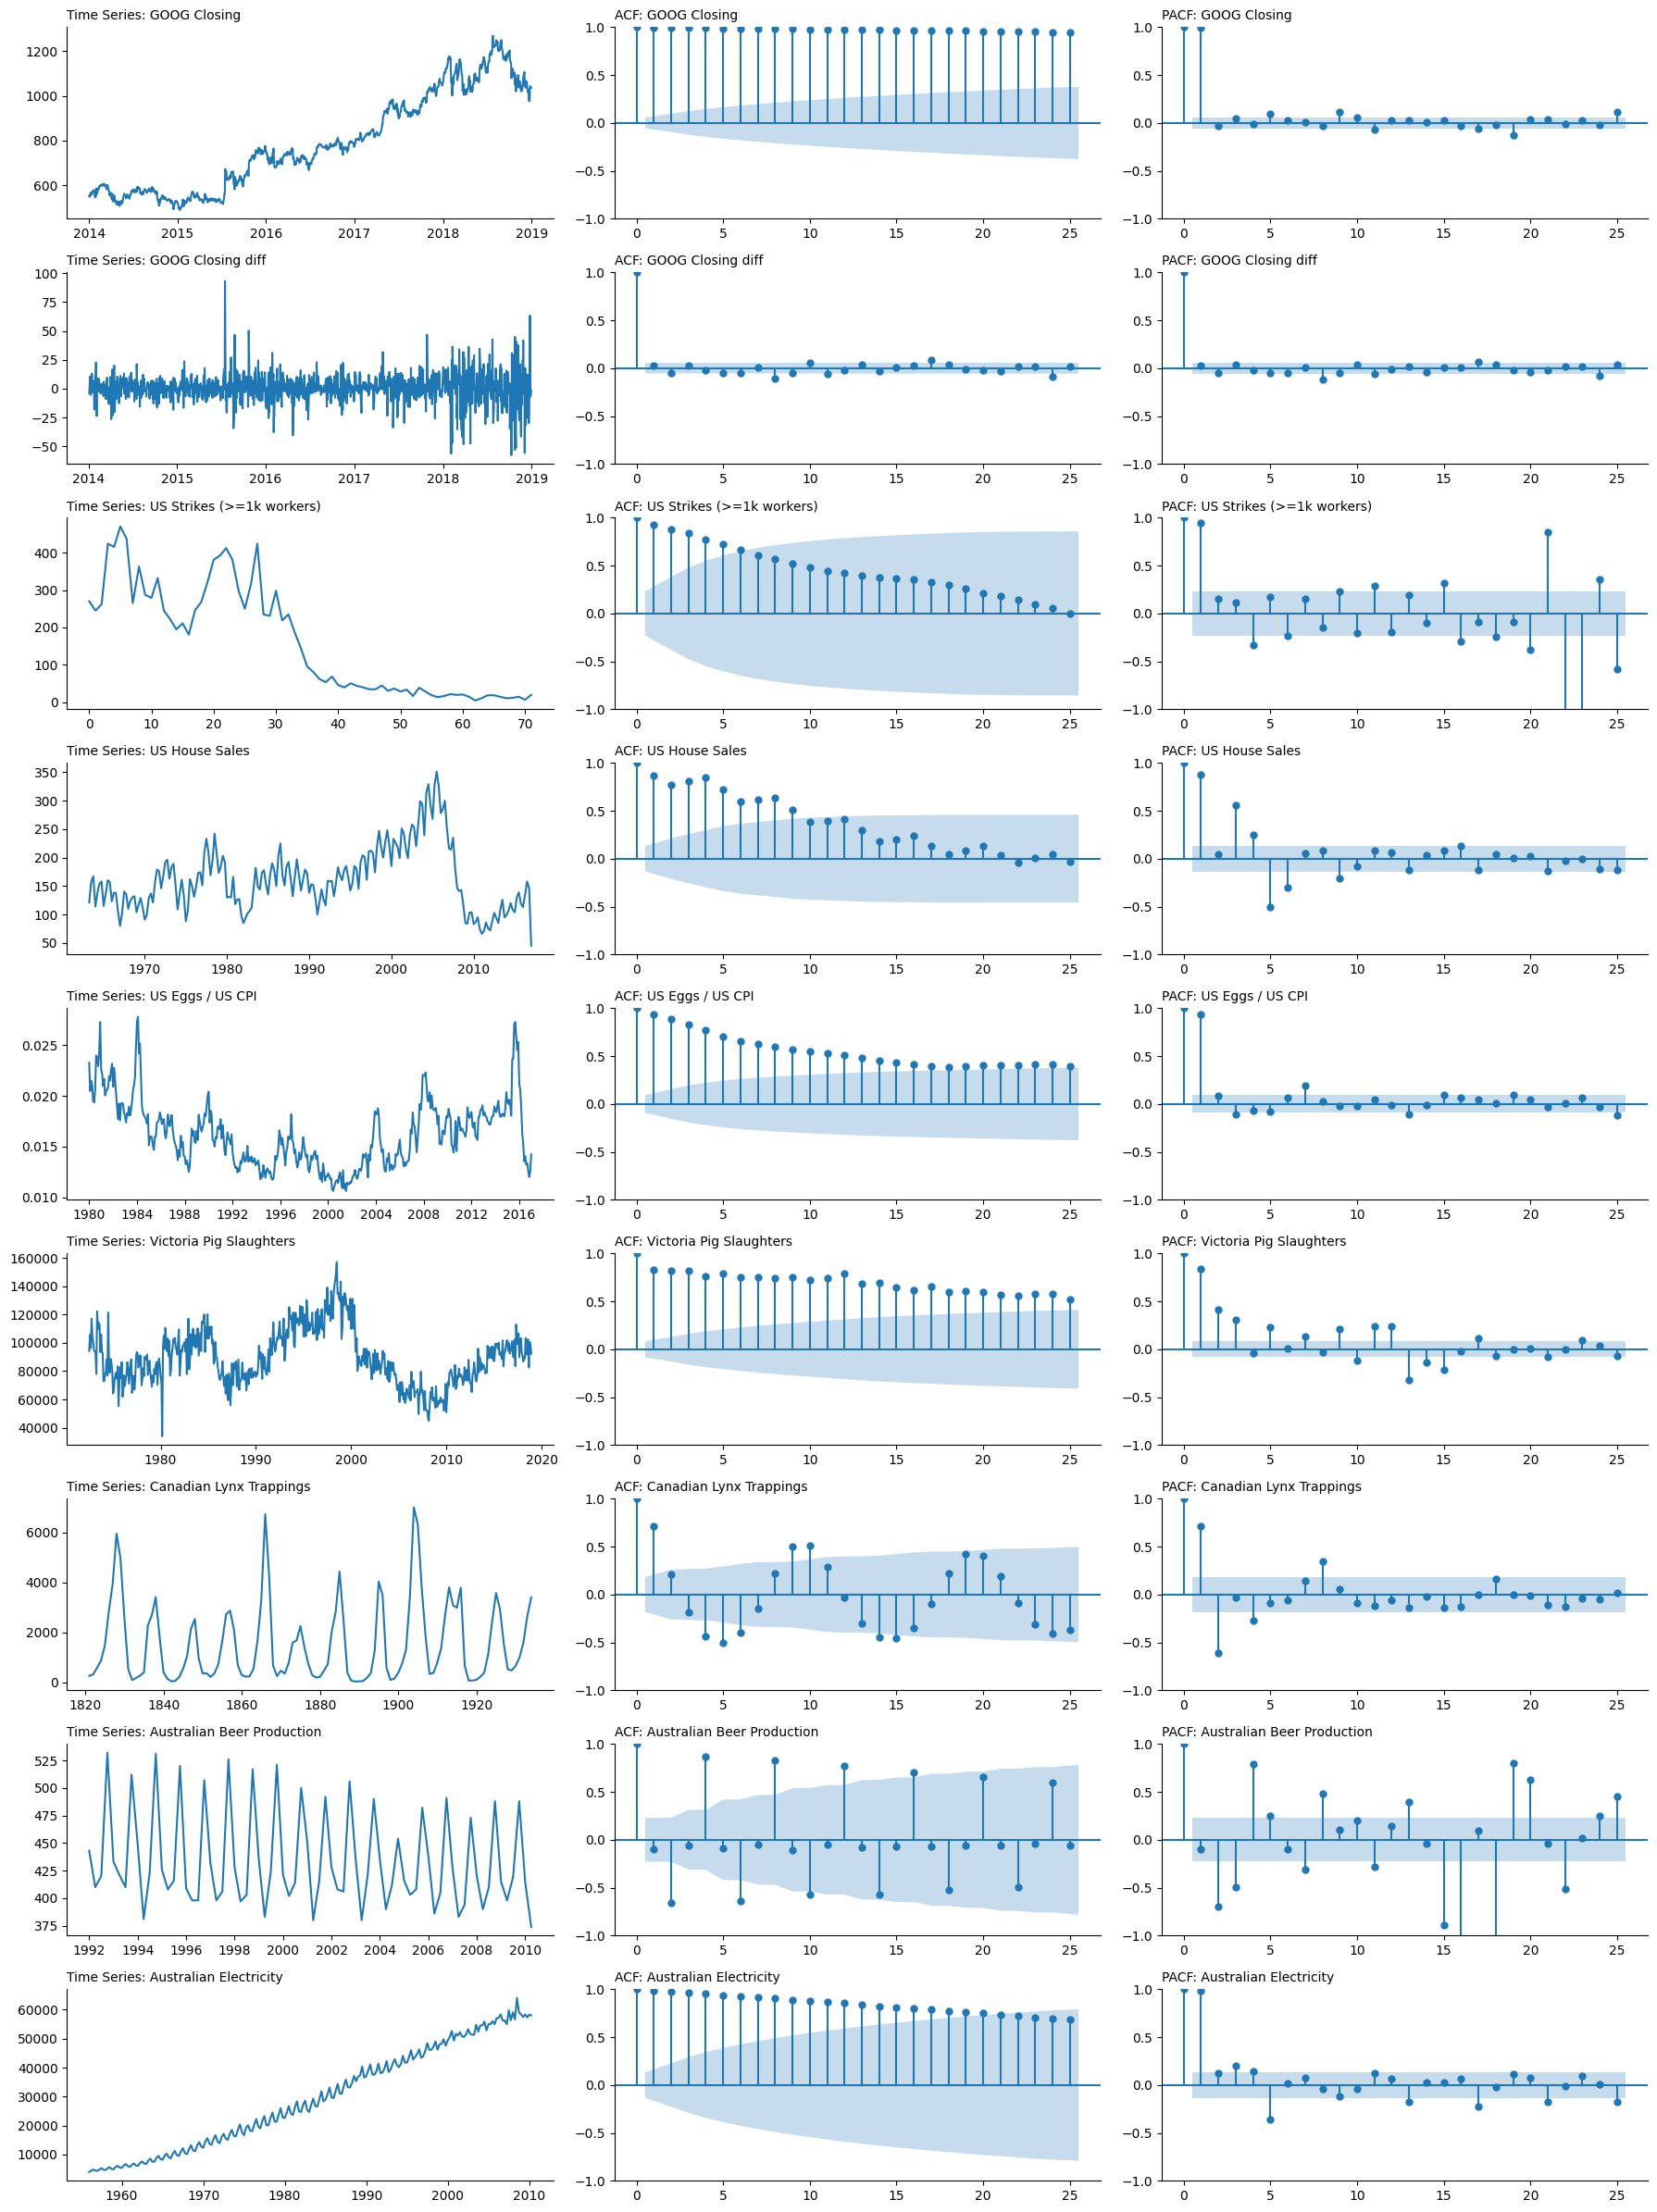

In [58]:
# Create a 9x3 subplot layout
fig, axs = plt.subplots(9, 3, figsize=(18, 24))
axs = axs.ravel()

# List of your timeseries data (replace these with actual data)
timeseries_data = [
    goog.Close, 
    goog.Close.diff().dropna(),
    strikes.Count, 
    housing.resample('1q').sum().Count, 
    (eggs.EggPrice / eggs.CPI).dropna(), 
    vic_pigs.Count,
    lynx.value,
    recent_production.Beer,
    aus_production.Electricity,
]

# Titles for each series
titles = [
    'GOOG Closing',
    'GOOG Closing diff',
    'US Strikes (>=1k workers)',
    'US House Sales',
    'US Eggs / US CPI',
    'Victoria Pig Slaughters',
    'Canadian Lynx Trappings',
    'Australian Beer Production',
    'Australian Electricity'
]

# Loop through each timeseries for plotting
for i, d in enumerate(timeseries_data):
    # Plot time series
    axs[3*i].plot(d)
    axs[3*i].set_title(f'Time Series: {titles[i]}')

    # Plot ACF
    sm.graphics.tsa.plot_acf(d, lags=25, ax=axs[3*i + 1])

    # Plot PACF
    sm.graphics.tsa.plot_pacf(d, lags=25, ax=axs[3*i + 2])
    
    axs[3*i + 1].set_title(f'ACF: {titles[i]}')
    axs[3*i + 2].set_title(f'PACF: {titles[i]}')

# Adjust layout
plt.tight_layout()
plt.show()


### 4.4 Estimation and order selection

#### Maximum Likelihood Estimation (MLE)

Once the model order has been identified (i.e., the values of $p$, $d$, and $q$), we need to estimate the parameters $c$, $\phi_1$, ..., $\phi_p$, $\theta_1$, ..., $\theta_q$. 

When estimating the ARIMA model, **maximum likelihood estimation (MLE)** is used. As we discussed before, the main idea is to find the values of the parameters which maximize the probability of obtaining the observed data. 

For ARIMA models, MLE is similar to the least squares estimates that would be obtained by minimizing:

$$
\sum_{t=1}^{T} \epsilon_t^2
$$

ARIMA models are more complicated to estimate than (simple) regression models and different software (or packages) will provide slightly different results as they use various methods of estimation and optimization algorithms.

#### Information Criteria

**Akaike’s Information Criterion (AIC)** is used for model selection, and it can be written as:

$$
AIC = -2 \log(L) + 2(p + q + k + 1)
$$

where:
- $L$ is the likelihood of the data,
- $k = 1$ if $c \neq 0$ and $k = 0$ if $c = 0$,
- The last term in parentheses is the number of parameters in the model (including $\sigma^2$, the variance of the residuals).

Good models are obtained by **minimizing** the AIC (or other criteria like BIC).

#### Important Considerations

- These information criteria are useful for selecting the values of $p$ and $q$, but they are **not** good guides for selecting the appropriate order of differencing ($d$).
- This is because differencing changes the data on which the likelihood is computed, making the AIC values between models with different orders of differencing not directly comparable.
- To select $d$, we need to use another approach and then use AIC to select $p$ and $q$.


### 4.5 Seasonal ARIMA Models

So far, we focused on non-seasonal data and non-seasonal ARIMA models. However, ARIMA models are also capable of modelling a wide range of seasonal data.

A seasonal ARIMA model is formed by including additional seasonal terms in the ARIMA models we have seen so far. It is written as follows:

$$
ARIMA(p, d, q) \times ARIMA(P, D, Q)_m
$$

where:

- The first part, $ARIMA(p, d, q)$, represents the non-seasonal components of the model,
- The second part, $ARIMA(P, D, Q)_m$, represents the seasonal components of the model,
- $m$ is the seasonal period (e.g., number of observations per year).

For example, a seasonal ARIMA model, denoted as $ (1, 1, 1) \times (1, 1, 1)_{12}$, is used to model time series data that exhibit a seasonal period $ m = 12 $.

Let's break this down a bit. Fist, left's define the backshift operator.
 
#### Backshift Operator:

$B$ is a mathematical operator that shifts a time series backward by one period. It is defined as:

$$
B y_t = y_{t-1}
$$

In other words, $ B $ applied to $ y_t $ gives the value of the series at time $ t-1 $. Similarly, higher powers of $ B $ shift the series by multiple periods:

$$
B^2 y_t = y_{t-2}, \quad B^3 y_t = y_{t-3}, \quad \dots
$$

For seasonal models, the backshift operator can be raised to the power of the seasonal period $ m $. For example, in a model with a seasonal period of 12 (i.e., $ m = 12 $):

$$
B^{12} y_t = y_{t-12}
$$

Thus, $ B^{12} $ shifts the series back by one full seasonal period (e.g., one year in monthly data).

#### Full Seasonal ARIMA Model (1,1,1)(1,1,1)$_{12}$:
$$
(1 - \phi_1 B)(1 - B)(1 - \Phi_1 B^{12})(1 - B^{12}) y_t = (1+ \theta_1 B)(1+\Theta_1 B^{12})\epsilon_t
$$

#### Explanation:

- The **non-seasonal part** of the model includes the AR and MA terms, as well as first-order differencing (represented by $(1-B)$).
- The **seasonal part** includes seasonal AR and MA terms, with seasonal differencing (represented by $ (1 - B^{12}) $) to remove seasonal trends.
- We are not computing $y_t$ directly.  
-- Instead, we are transforming $y_t$ into a stationary process (left-hand side) and modeling it as a function of past error terms (right-hand side).  
-- This allows us to make predictions because once we estimate $\phi_1, \theta_1, \Phi_1, \Theta_1$ we can generate forecasts using past data.



The seasonal part of an AR or MA model will be seen in the *seasonal* lags of the PACF and ACF.

For example, an ARIMA$(0,0,0)(0,0,1)_{12}$ model will show:

- A spike at lag 12 in the ACF but no other significant spikes;
- Exponential decay in the seasonal lags of the PACF (i.e., at lags 12, 24, 36, …).


Similarly, an ARIMA$(0,0,0)(1,0,0)_{12}$ model will show:

- Exponential decay in the seasonal lags of the ACF;
- A single significant spike at lag 12 in the PACF.


In considering the appropriate seasonal orders for a seasonal ARIMA model, restrict attention to the seasonal lags.


The modelling procedure is almost the same as for non-seasonal data, except that we need to select seasonal AR and 
MA terms as well as the non-seasonal components of the model. The process is best illustrated via examples.

### 4.5 Example: Corticosteroid drug sales in Australia (also with forecasting)

In [92]:
h02 = (
    PBS
    .query('ATC2 == "H02"')
    .groupby('Month', sort=False)
    .pipe(summarize, lambda x: dict(Cost = x.Cost.sum() / 1e6)) #divide by million
    .reset_index()
    .set_index('Month', drop=False)
)
h02

Month      Cost
Month                          
1991-07-01 1991-07-01  0.429795
1991-08-01 1991-08-01  0.400906
1991-09-01 1991-09-01  0.432159
1991-10-01 1991-10-01  0.492543
1991-11-01 1991-11-01  0.502369
...               ...       ...
2008-02-01 2008-02-01  0.761822
2008-03-01 2008-03-01  0.649435
2008-04-01 2008-04-01  0.827887
2008-05-01 2008-05-01  0.816255
2008-06-01 2008-06-01  0.762137

[204 rows x 2 columns]

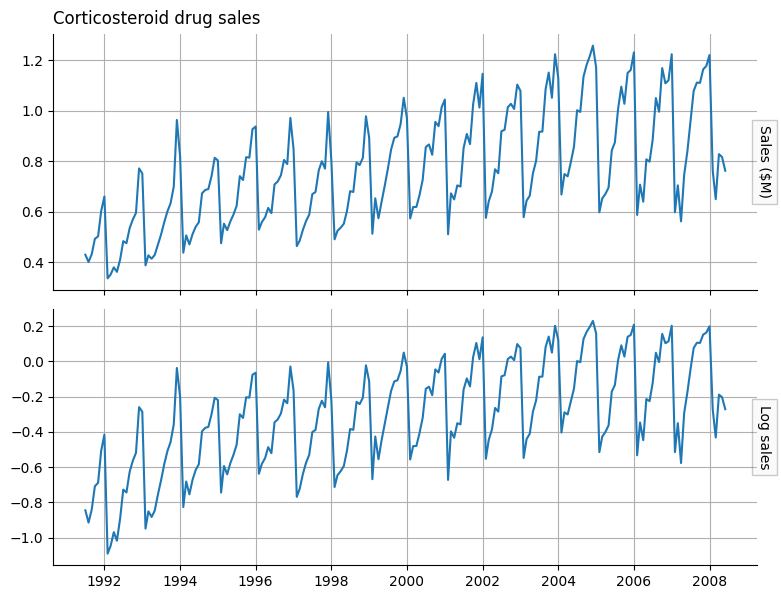

In [93]:
fig, axs = plt.subplots(2, 1, figsize=(8,6), sharex=True)
d = h02
axs[0].plot(d.Cost)
axs[1].plot(np.log(d.Cost))
titles = 'Sales ($M)', 'Log sales', 'Annual $\Delta\ln$', '$\Delta$ Annual $\Delta\ln$'
for (ax, title) in zip(axs, titles):
    rlabel(ax, title)
    ax.grid()
plt.tight_layout()
suptitle('Corticosteroid drug sales')
fig.subplots_adjust(top=.95)

We check the original timeseries and it's shifted-by-12-version with the function below

In [95]:
def plot_tsresiduals(Y, y, acf_lags=np.r_[1:26]):
    """Plot timeseries residuals for ground truth Y and estimate y."""
    fig = plt.figure()
    gs = plt.GridSpec(3, 2, figure=fig)
    ts_ax = fig.add_subplot(gs[0,:])
    axs = np.array([ts_ax] + [fig.add_subplot(gs[i,j]) for j in (0,1) for i in (1,2)])
    ax, rax, hax, acfax, pacfax = axs
    #((ax, hax), (rax, acfax)) = axs
    mask = ~(np.isnan(Y) | np.isnan(y))
    Y, y = Y[mask], y[mask]
    dy = Y - y
    ax.plot(Y, color='k')
    ax.plot(y)
    ax.set(title='Time Series')
    lim = 1.1 * max(-dy.min(), dy.max())
    lim = -lim, lim
    rax.plot(dy)
    rax.set(ylim=lim, title='Residuals')
    sns.distplot(dy, bins=np.linspace(lim[0], lim[1], 22),
                 hist=True, kde=True, rug=True, ax=hax)
    hax.set(title='Residual Distribution')
    sm.graphics.tsa.plot_acf(dy, lags=acf_lags, ax=acfax)
    sm.graphics.tsa.plot_pacf(dy, lags=acf_lags, ax=pacfax)
    for a in axs.ravel():
        a.grid()
    plt.tight_layout()
    return fig, axs

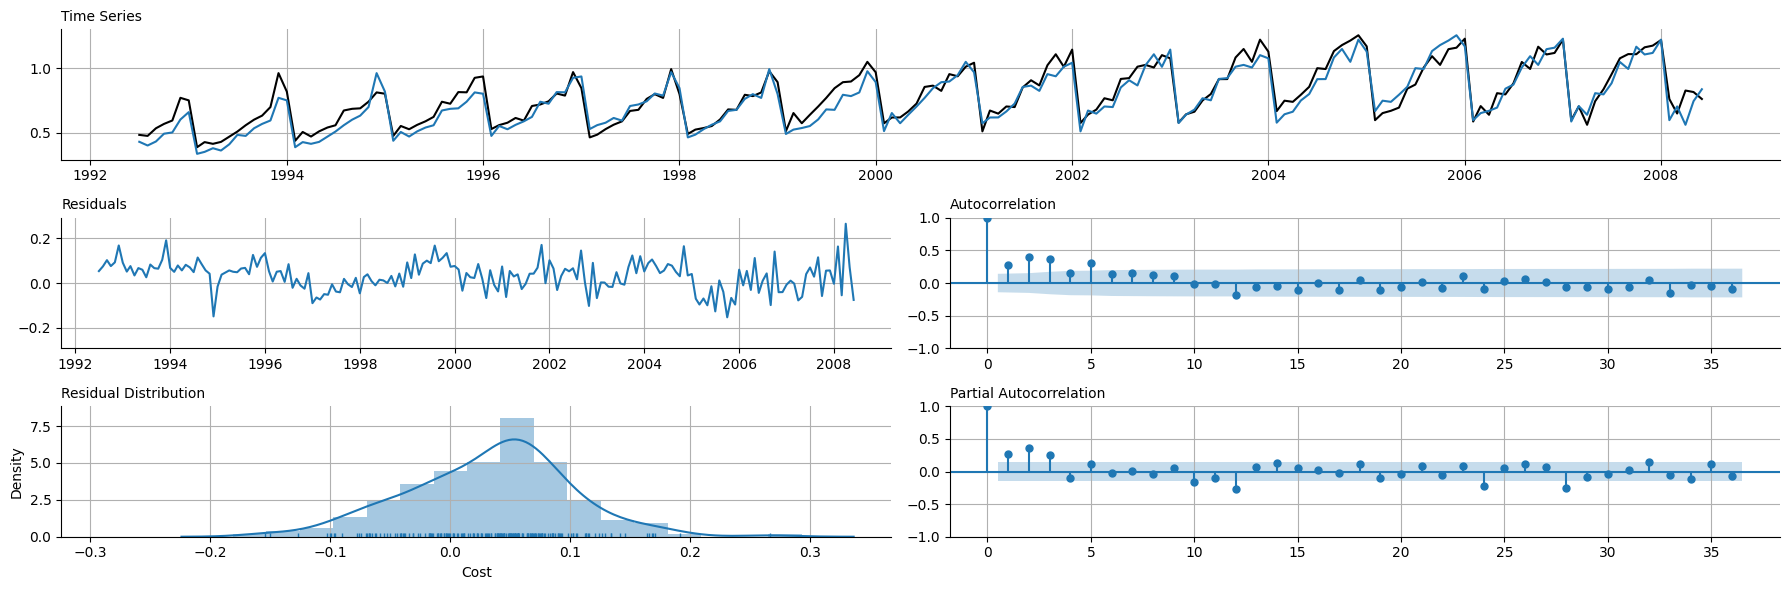

In [96]:
plot_tsresiduals(h02.Cost, h02.Cost.shift(12), acf_lags=36);

- Spikes in PACF at lags 12 and 24, suggest a seasonal AR(2) term.
- Spikes in PACF suggests non-seasonal AR(3) term.
- For differencing we could go with 1 for both. Let's choose $D=1$ and $d=0$


So one initial candidate could be ARIMA$(3,0,0)(2,1,0)_{12}$

We will try to fit some different models.

In [97]:
%%time

# Initialize a list to store results
results = []

# Define the hyperparameters
p, d, Q, D, m = 3, 0, 1, 1, 12

# Use itertools to generate combinations of (q, P, D) for seasonal parameters
for (q, P, Q) in tqdm(list(itertools.product(range(2), range(3), range(3)))):  # added D
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        try:
            # Fit the SARIMAX model
            fit = sm.tsa.SARIMAX(np.log(h02.Cost), order=(p, d, q), seasonal_order=(P, D, Q, m)).fit(disp=0)
            
            # Store the results
            result = dict(p=p, q=q, d=d, P=P, D=D, Q=Q, m=m,
                          label=f'SARIMA({p},{d},{q})({P},{D},{Q}){m}',
                          AIC=fit.aic, fit=fit)
            results.append(result)
        except Exception as e:
            print(f"Error for model (p={p}, d={d}, q={q}, P={P}, D={D}, Q={Q}): {e}")
            
# Convert results to DataFrame
results_df = pd.DataFrame(results)
# Display results
#print(results_df)

100%|███████████████████████████████████████████| 18/18 [00:22<00:00,  1.27s/it]

CPU times: user 2min 16s, sys: 48.9 s, total: 3min 5s
Wall time: 23 s


In [98]:
results_df.sort_values('AIC')['label AIC'.split()]

label         AIC
17  SARIMA(3,0,1)(2,1,2)12 -487.498851
16  SARIMA(3,0,1)(2,1,1)12 -486.421720
11  SARIMA(3,0,1)(0,1,2)12 -486.082271
2   SARIMA(3,0,0)(0,1,2)12 -484.987949
13  SARIMA(3,0,1)(1,1,1)12 -484.860213
14  SARIMA(3,0,1)(1,1,2)12 -484.494760
7   SARIMA(3,0,0)(2,1,1)12 -484.488747
8   SARIMA(3,0,0)(2,1,2)12 -484.355567
4   SARIMA(3,0,0)(1,1,1)12 -484.299460
1   SARIMA(3,0,0)(0,1,1)12 -484.189627
10  SARIMA(3,0,1)(0,1,1)12 -484.116907
5   SARIMA(3,0,0)(1,1,2)12 -483.166367
15  SARIMA(3,0,1)(2,1,0)12 -476.832194
6   SARIMA(3,0,0)(2,1,0)12 -475.577428
3   SARIMA(3,0,0)(1,1,0)12 -464.800268
12  SARIMA(3,0,1)(1,1,0)12 -463.849449
9   SARIMA(3,0,1)(0,1,0)12 -451.795479
0   SARIMA(3,0,0)(0,1,0)12 -449.720499

Based on these observations, I can pick a model considering also the trade-offs between small differences in the AIC compared to a model with a larger number of parameters and check the fit.

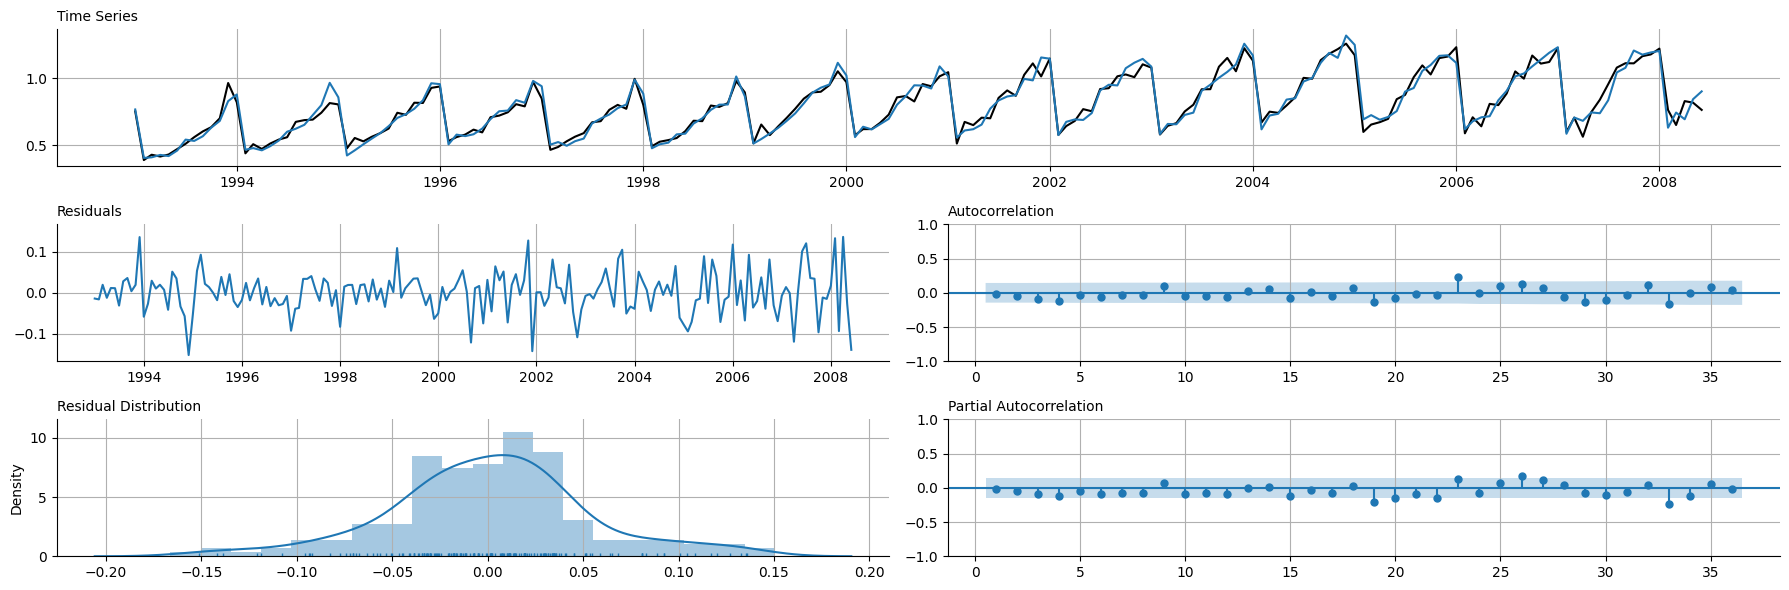

In [99]:
selected_model=11

plot_tsresiduals(h02.Cost['1993':], np.exp(results_df.iloc[selected_model].fit.fittedvalues['1993':]),
                 acf_lags=np.r_[1:37]);

### Test set evaluation

Previously, we considered the whole timeseries. We will now split to training/testing. This is a timeseries, so remember a random split is not the best option since the data is temporal.

In [100]:
split = '2006-06-02'
tend = '2008-06-02'
dtrain, dtest = h02[:split], h02[split:tend]

In [101]:
m = sm.tsa.SARIMAX(np.log1p(dtrain.Cost), order=(3, 0, 1), seasonal_order=(0,1,2,12))
fit = m.fit(disp=0)
fit.summary()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                    Cost   No. Observations:                  180
Model:             SARIMAX(3, 0, 1)x(0, 1, [1, 2], 12)   Log Likelihood                 372.183
Date:                                 Thu, 27 Feb 2025   AIC                           -730.365
Time:                                         12:10:41   BIC                           -708.498
Sample:                                     07-01-1991   HQIC                          -721.490
                                          - 06-01-2006                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0136      0.251      0.054      0.957      -0.478       0.505
ar.L2          0.5199      0.121      4.284      0.000       0.282       0.758
ar.L3          0.3919      0.137      2.861      0.004       0.123       0.660
ma.L1          0.2537      0.268      0.947      0.344      -0.272       0.779
ma.S.L12      -0.3791      0.088     -4.318      0.000      -0.551      -0.207
ma.S.L24      -0.2249      0.100     -2.242      0.025      -0.422      -0.028
sigma2         0.0007   7.12e-05      9.459      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 3.79
Prob(Q):                              0.91   Prob(JB):                         0.15
Heteroskedasticity (H):               1.40   Skew:                            -0.26
Prob(H) (two-sided):                  0.21   Kurtosis:                         3.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

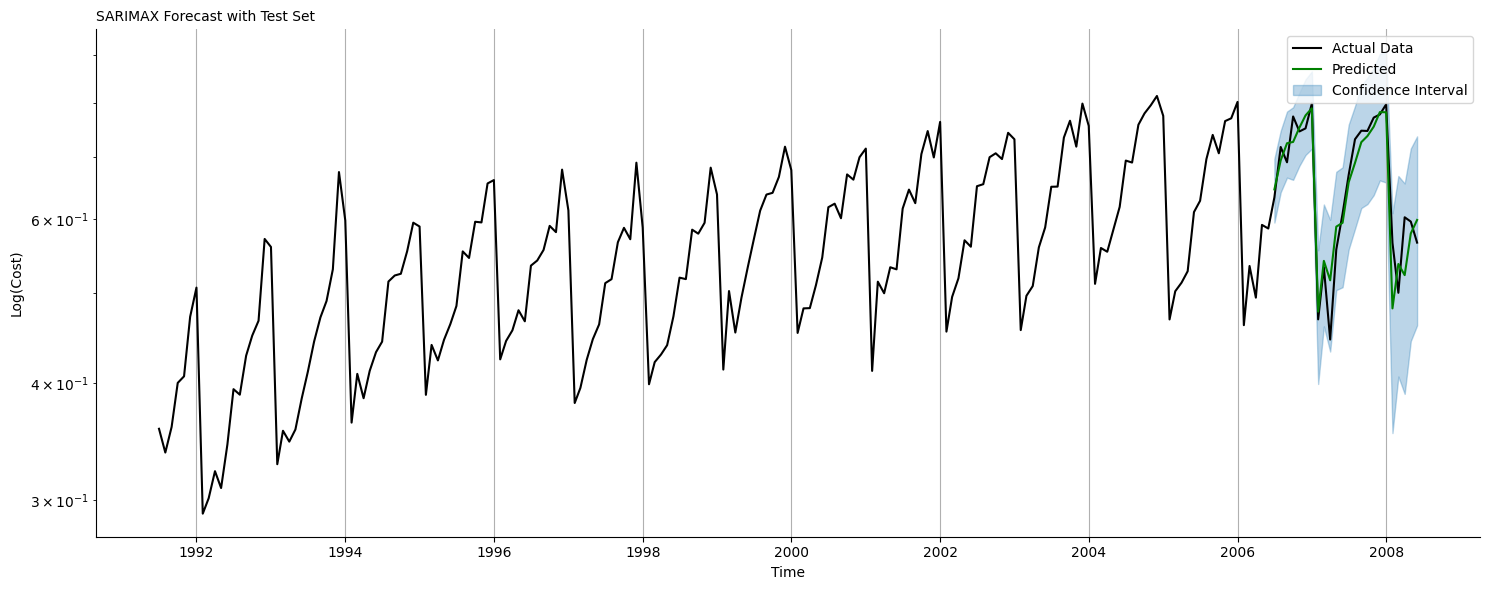

In [102]:
# Create the figure for plotting
fig, ax = plt.subplots(figsize=(15, 6))

# Plot the entire time series (both training and test data)
ax.plot(np.log1p(h02.Cost), 'k', label='Actual Data')

# Set the y-axis to use a logarithmic scale
ax.semilogy()

# Get forecast predictions for the test set
fc = fit.get_forecast(2*12)

# Plot the predicted mean values from the forecast
ax.plot(fc.predicted_mean, color="g", label='Predicted')

# Get the confidence intervals for the forecast
ci = fc.conf_int()

# Fill between the confidence intervals for visualization
ax.fill_between(fc.predicted_mean.index, ci.iloc[:, 0], ci.iloc[:, 1], color='C0', alpha=0.3, label='Confidence Interval')

# Set grid and labels
ax.grid()
ax.set_title('SARIMAX Forecast with Test Set')
ax.set_xlabel('Time')
ax.set_ylabel('Log(Cost)')

# Show legend
ax.legend()

# Display the plot
plt.tight_layout()
plt.show()


### Computing the prediction error

We can either do it for the whole test set, or limit our exploration to the first e.g. 5 values.

In [103]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [104]:
mae = mean_absolute_error(dtest.Cost, fc.predicted_mean.values)
mse = mean_squared_error(dtest.Cost, fc.predicted_mean.values)

print("MAE (test): {:0.3f}".format(mae))
print("MSE (test): {:0.3f}".format(mse))

MAE (test): 0.289
MSE (test): 0.097


I can also evaluate only for the next $k$ points (more accurate)

In [105]:
k=5
mae = mean_absolute_error(dtest.Cost[:k], fc.predicted_mean.values[:k])
mse = mean_squared_error(dtest.Cost[:k], fc.predicted_mean.values[:k])

print("MAE (test): {:0.3f}".format(mae))
print("MSE (test): {:0.3f}".format(mse))

MAE (test): 0.332
MSE (test): 0.116


Below we do the same process for the alcohol dataset we loaded 

In [106]:
train_range = alcohol[alcohol.period < '2020-01-01'].index
test_range = alcohol[(alcohol.period >= '2020-01-01')].index

#from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace import sarimax

In [107]:
model = sarimax.SARIMAX(
    np.log(alcohol.loc[train_range].set_index("period").value),
    trend='n', #identifies non-constant trend (other options: c for constant etc.)
    order=(1,1,1),
    seasonal_order=(1,1,1,12), #seasonal component
    enforce_stationarity=True,
    enforce_invertibility=True)

results = model.fit(disp=0)
print(results.summary())

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



                                     SARIMAX Results                                      
Dep. Variable:                              value   No. Observations:                  384
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 560.411
Date:                            Thu, 27 Feb 2025   AIC                          -1110.822
Time:                                    12:12:04   BIC                          -1091.241
Sample:                                01-01-1988   HQIC                         -1103.045
                                     - 12-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1724      0.091     -1.890      0.059      -0.351       0.006
ma.L1         -0.2660      0.092   

### Making predictions and evaluating the model

In [109]:
steps = test_range.shape[0]

forecast = results.get_forecast(steps=steps)
forecast_ci = forecast.conf_int()

yhat_test = np.exp(forecast.predicted_mean).values
y_test = alcohol.loc[test_range].value.values

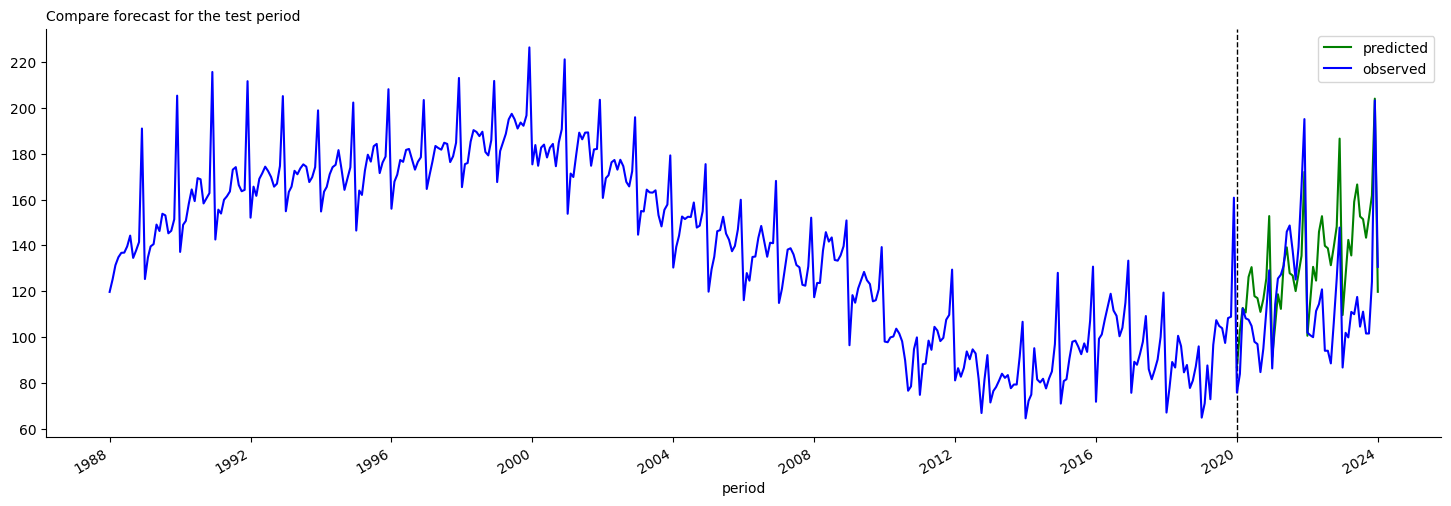

In [112]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(pd.to_datetime(alcohol.loc[test_range].period.values), yhat_test,
        color="green", label="predicted")

plt.axvline(pd.to_datetime(str(alcohol.loc[test_range].period.values[0])), c='black', ls='--', lw=1)
alcohol.plot(x="period", y="value", color="blue", ax=ax, label="observed")

plt.legend(loc='best')
plt.title('Compare forecast for the test period')

#plt.savefig('images/stochastic-forecast-testrange.png')
plt.show();

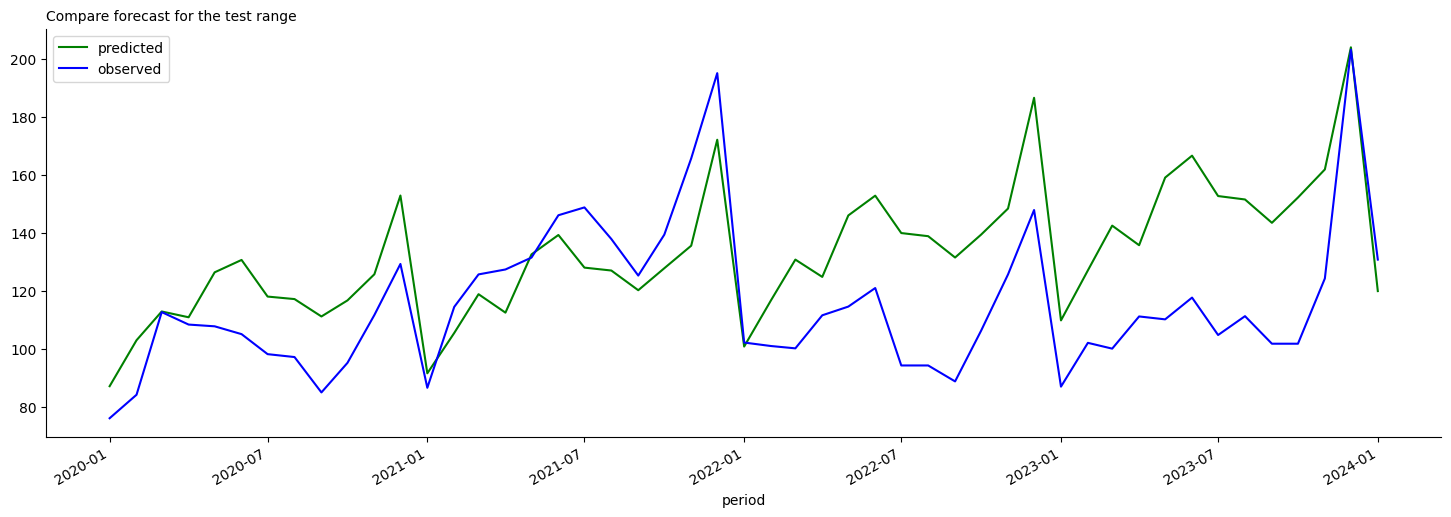

In [113]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(pd.to_datetime(alcohol.loc[test_range].period.values), yhat_test, color="green", label="predicted")

alcohol.loc[test_range].plot(x="period", y="value", ax=ax, color = "blue", label="observed")
plt.legend(loc='best')
plt.title('Compare forecast for the test range')

#plt.savefig('images/stochastic-forecast-testrange-zoom.png')
plt.show();

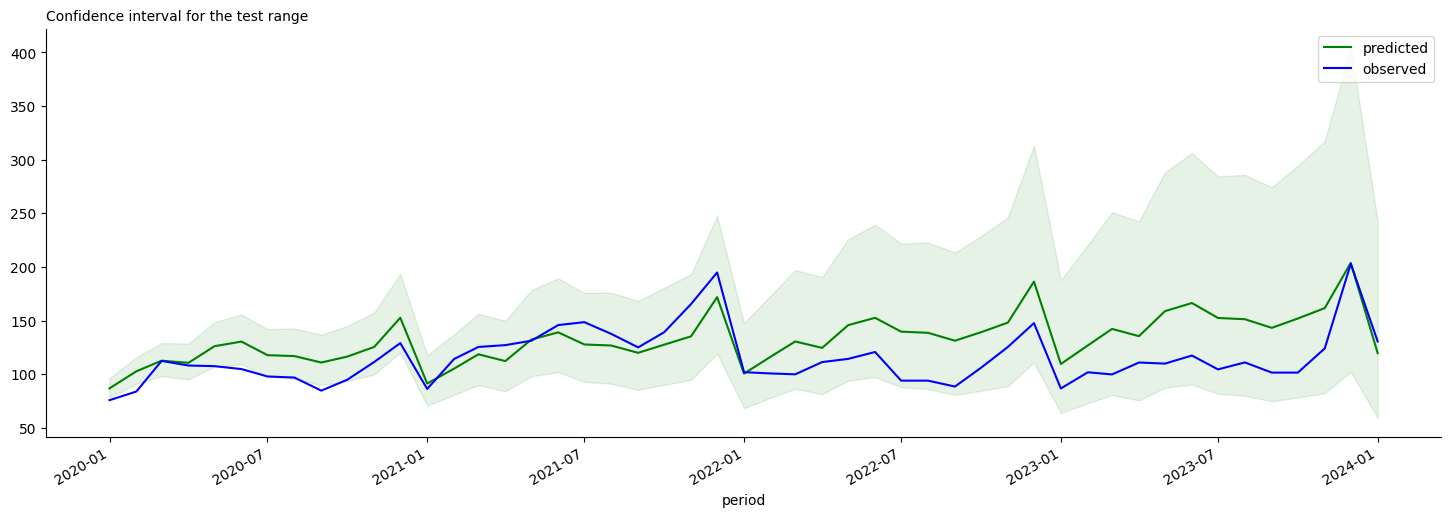

In [115]:
fig, ax = plt.subplots(figsize=(18,6))
ax.plot(pd.to_datetime(alcohol.loc[test_range].period.values), yhat_test,
        color="green", label="predicted")

ax.fill_between(
    forecast_ci.index.to_pydatetime(),
    np.exp(forecast_ci['lower value']),
    np.exp(forecast_ci['upper value']),
    color='g',
    alpha=0.1)

alcohol.loc[test_range].plot(x="period", y="value", ax=ax, color="blue",label="observed")

plt.legend(loc='best')
plt.title('Confidence interval for the test range')

#plt.savefig('images/stochastic-forecast-testrange-confidence-interval.png')
plt.show();

### Evaluate the forecast

In [116]:
mae = mean_absolute_error(y_test, yhat_test)
mse = mean_squared_error(y_test, yhat_test)

print("MAE (test): {:0.3f}".format(mae))
print("MSE (test): {:0.3f}".format(mse))

MAE (test): 23.284
MSE (test): 758.752


### Evaluate the prediction for near-future (12 months) only

In [117]:
mae = mean_absolute_error(y_test[:12], yhat_test[:12])
mse = mean_squared_error(y_test[:12], yhat_test[:12])

print("MAE (test): {:0.3f}".format(mae))
print("MSE (test): {:0.3f}".format(mse))

MAE (test): 16.833
MSE (test): 348.426
